# DSA5204 DEEP LEARNING AND APPLICATIONS
## GROUP 18
#### Kang Mingyue A0262127L
#### Peng Hanqiu A0179035B
#### Ren Lianhai A0262042U
#### Wu Shiqi A0262031X
#### Zhang Jingguo A0262029J

In [2]:
!nvidia-smi

Thu Apr 20 21:43:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:18:00.0 Off |                  N/A |
| 33%   60C    P8    32W / 350W |      8MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:51:00.0 Off |                  N/A |
| 49%   

In [2]:
from dsa5204_project_utils import *
tf.__version__

2023-04-12 15:29:39.469719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 15:29:39.553846: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


'2.11.0'

In [3]:
tf.config.list_physical_devices('GPU')
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[1], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [4]:
use_mixed_float16=False
#learning related configurations
lr_base=5e-4 #0.016
lr_min=0
lr_decay_epoch=2.4
lr_decay_factor=0.97
batch_size=500 #4096
scaled_lr=lr_base*batch_size/256.
scaled_lr_min=lr_min*batch_size/256.
steps_per_epoch=500


In [5]:
'''
Some configuration used in model construction
'''
act=keras.activations.gelu
depth_divisor=8
min_depth=8
survival_prob=0.8
dropout=0.2
nclasses=10
conv_dropout=None

#b0_config
v2_base_block = [ # The baseline config for v2 models.
'r1_k3_s1_e1_i32_o16_c1',
'r2_k3_s2_e4_i16_o32_c1',
'r2_k3_s2_e4_i32_o48_c1',
'r3_k3_s2_e4_i48_o96_se0.25',
'r5_k3_s1_e6_i96_o112_se0.25',
'r8_k3_s2_e6_i112_o192_se0.25',
]

v2_base_block_modified2 = [ # The baseline config for v2 models.
'r1_k3_s1_e1_i32_o16_c1',
'r2_k3_s2_e4_i16_o32_c1',
'r2_k3_s1_e4_i32_o48_c1',
'r3_k3_s1_e4_i48_o96_se0.25',
'r5_k3_s1_e6_i96_o112_se0.25',
'r8_k3_s2_e6_i112_o192_se0.25',
]

v2_base_block_modified = [ # The baseline config for v2 models.
'r1_k3_s1_e1_i32_o16_c1',
'r1_k3_s1_e4_i16_o32_c1',
'r1_k3_s1_e4_i32_o48_c1',
'r2_k3_s2_e4_i48_o96_se0.25',
'r2_k3_s1_e6_i96_o112_se0.25',
'r5_k3_s2_e6_i112_o192_se0.25',
]

'''
structure modified from ConvNeXt:
    1:1:3:1 stage ratio, 
    7x7 kernel, 
    more filters, 
    only use depthwise convolution
'''

v2_base_block_modified3 = [
'r3_k7_s2_e4_i16_o32_c0',
'r3_k7_s1_e4_i32_o64_c0',
'r9_k7_s2_e4_i64_o128_se0.25_c0',
'r3_k7_s1_e4_i128_o256_se0.25_c0',
]

v2_base_block_modified4 = [
'r3_k7_s1_e4_i16_o32_c1',
'r3_k7_s2_e4_i32_o48_c1',
'r9_k7_s2_e4_i48_o96_se0.25_c0',
'r3_k7_s1_e4_i96_o180_se0.25_c0',
]

# Model Construction

# Data Preparing

In [6]:
#import the necessary package
# from keras.datasets import cifar10
#download the CIFAR10 dataset
# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [7]:
# np.savez(os.path.join(model_path,'data'),x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)

In [6]:
model_path = './saved_model'

In [7]:
#load the CIFAR10 dataset
data=np.load(os.path.join(model_path,'data.npz'))
x_train, y_train, x_test, y_test=data['x_train'],data['y_train'],data['x_test'],data['y_test']

In [8]:
#change the label to one-hot coding
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

In [11]:
# #download the pre-trained EfficientNetV2 model
# truemodel=keras.applications.EfficientNetV2B0(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=10,
#     classifier_activation="softmax",
#     include_preprocessing=False,
# )

Random Augmentation (without mixup,cutmix)
https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

In [12]:
#Some config, No used yet

available_ops = [
      'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize',
      'Solarize', 'Color', 'Contrast', 'Brightness', 'Sharpness',
      'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Cutout', 'SolarizeAdd']

translate_const=100
cutout_const=40
replace_value = [128] * 3
_MAX_LEVEL = 10.


In [13]:

if use_mixed_float16:
  keras.mixed_precision.set_global_policy('float32')

In [14]:
# AUTOTUNE = tf.data.AUTOTUNE
# ag_pipeline=Set_levels(1)
# preparing=functools.partial(preparing_withscale,ag_pipeline=ag_pipeline)
# #construct dataset for implement augmentation
# train_ds=tf.data.Dataset.from_tensor_slices(dict(images=x_train,labels=tf.cast(y_train,tf.float32)))
# train_ds=(train_ds.batch(batch_size)
#                 .map(preparing, num_parallel_calls=AUTOTUNE)
#                 .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
#                   .prefetch(AUTOTUNE))

In [15]:
if use_mixed_float16:
  keras.mixed_precision.set_global_policy('mixed_float16')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds=tf.data.Dataset.from_tensor_slices(dict(images=x_train,labels=tf.cast(y_train,tf.float32)))
valid_ds=train_ds.take(5000).batch(batch_size)
valid_ds=valid_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds=(tf.data.Dataset.from_tensor_slices(dict(images=x_train,labels=tf.cast(y_train,tf.float32)))
        .batch(batch_size)
        .map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        )

2023-04-12 15:29:55.970393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 15:29:56.600914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21237 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:51:00.0, compute capability: 8.6


In [17]:

keras.mixed_precision.set_global_policy('float32')
if use_mixed_float16:
  keras.mixed_precision.set_global_policy('mixed_float16')

'''
EfficientNetV2 backbone construct
'''
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block_modified))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [10]:
def fit_stage(stage,lr_base=0.016,lr_min=0,lr_decay_epoch=2.4,lr_decay_factor=0.97,batch_size=1024,steps_per_epoch=500,
             weight_decay=1e-5,epochs=20,model_path=model_path,_MAX_LEVEL=10,
              enable_cut_mix_and_mix_up=False,use_paper_rand_augment=False,imagesize=None,progressive_fn=lambda x: x):
    scaled_lr=lr_base*batch_size/256.
    scaled_lr_min=lr_min*batch_size/256.
    

    AUTOTUNE = tf.data.AUTOTUNE
    
    if imagesize:
        resize_layer=tf.keras.layers.Resizing(imagesize, imagesize, interpolation="bilinear",)
    
    strength=progressive_fn(stage)
    if use_paper_rand_augment:
        ag_pipeline=Set_levels(strength)
        preparing=functools.partial(preparing_withscale,ag_pipeline=ag_pipeline)
    else:
        preparing=keras_cv.layers.RandAugment(value_range=(0, 255), magnitude=strength/_MAX_LEVEL, magnitude_stddev=0.3)
    
    if imagesize:
        def apply_rand_augment(samples):
            samples["images"] = preparing(resize_layer(samples["images"]))
            return samples
    else:
        def apply_rand_augment(samples):
            samples["images"] = preparing(samples["images"])
            return samples
    

    #learning related configurations
    #construct dataset for implement augmentation
    train_ds=tf.data.Dataset.from_tensor_slices(dict(images=x_train,labels=tf.cast(y_train,tf.float32)))
    valid_ds=train_ds.take(5000)
    train_ds=train_ds.skip(5000)
    train_ds=(train_ds.batch(batch_size)
                    .map(preparing, num_parallel_calls=AUTOTUNE))
    if enable_cut_mix_and_mix_up:
        train_ds=train_ds.map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
    train_ds=train_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    valid_ds=valid_ds.batch(500).map(preprocess_for_model, num_parallel_calls=AUTOTUNE) #useless
    
    mylr=WarmupLearningRateSchedule(
                        initial_lr=scaled_lr,
                        steps_per_epoch=steps_per_epoch,
                        warmup_epochs=5,
                        after_warmup_schedule=keras.optimizers.schedules.ExponentialDecay(scaled_lr,
                                                                                          decay_steps=lr_decay_epoch*steps_per_epoch,
                                                                                          decay_rate=lr_decay_factor,
                                                                                          staircase=True),
                        # last_epoch=last_epoch,
                        )
    opt=keras.optimizers.experimental.AdamW(learning_rate=mylr,weight_decay=weight_decay)
    callbacks=[
    keras.callbacks.ModelCheckpoint(
        os.path.join(model_path,f's{stage}-'+'{epoch:02d}-{acc:.2f}.hdf5'),
        monitor= "acc",
        save_best_only = True,
        save_weights_only = True,
        save_freq=100,
    ),
    keras.callbacks.TensorBoard(
        log_dir=os.path.join(model_path,'logs'+str(stage)),
        histogram_freq=0,
        write_graph=False,
        write_images=False,
        write_steps_per_second=False,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0,
        embeddings_metadata=None,
    )
    ]
    #compile model
    Mymodel.compile(
#                         keras.mixed_precision.LossScaleOptimizer(opt),
                        opt,
#                         add_l2_loss(keras.losses.categorical_crossentropy,l2scale,Mymodel,mix_precition=use_mixed_float16),
                        keras.losses.categorical_crossentropy,
                        metrics=[keras.metrics.CategoricalAccuracy(name='acc'),
                                 keras.metrics.TopKCategoricalAccuracy(k=2,name='top2_acc'),
                                 keras.metrics.TopKCategoricalAccuracy(k=3,name='top3_acc'),
                                 keras.metrics.TopKCategoricalAccuracy(k=5,name='top5_acc')],
                        )
    Mymodel.fit(train_ds.repeat(),epochs=epochs,steps_per_epoch=steps_per_epoch,callbacks=callbacks,validation_data=valid_ds)

In [ ]:
Mymodel.fit(train_ds.repeat(),epochs=50,steps_per_epoch=steps_per_epoch,callbacks=callbacks)

Epoch 8/50
500/500 [==============================] - 349s 698ms/step - loss: 0.9934 - acc: 0.7205 - top1_acc: 0.7205 - top2_acc: 0.8578 - top3_acc: 0.9179 - top5_acc: 0.9714
Epoch 9/50
500/500 [==============================] - 769s 2s/step - loss: 0.8472 - acc: 0.7636 - top1_acc: 0.7636 - top2_acc: 0.8864 - top3_acc: 0.9363 - top5_acc: 0.9786
Epoch 10/50
500/500 [==============================] - 805s 2s/step - loss: 0.8315 - acc: 0.7706 - top1_acc: 0.7706 - top2_acc: 0.8910 - top3_acc: 0.9395 - top5_acc: 0.9795
Epoch 11/50
500/500 [==============================] - 815s 2s/step - loss: 0.8656 - acc: 0.7691 - top1_acc: 0.7691 - top2_acc: 0.8897 - top3_acc: 0.9384 - top5_acc: 0.9795
Epoch 12/50
500/500 [==============================] - 966s 2s/step - loss: 0.9084 - acc: 0.7659 - top1_acc: 0.7659 - top2_acc: 0.8884 - top3_acc: 0.9376 - top5_acc: 0.9786
Epoch 13/50
500/500 [==============================] - 1064s 2s/step - loss: 0.9468 - acc: 0.7601 - top1_acc: 0.7601 - top2_acc: 0.884

In [85]:
fit_stage(2,lr_base=1e-3,epochs=50)

Epoch 1/50
500/500 [==============================] - 640s 1s/step - loss: 0.5045 - acc: 0.8792 - top1_acc: 0.8792 - top2_acc: 0.9496 - top3_acc: 0.9736 - top5_acc: 0.9915
Epoch 2/50
500/500 [==============================] - 616s 1s/step - loss: 0.4715 - acc: 0.8904 - top1_acc: 0.8904 - top2_acc: 0.9545 - top3_acc: 0.9762 - top5_acc: 0.9922
Epoch 3/50
500/500 [==============================] - 624s 1s/step - loss: 0.4624 - acc: 0.8924 - top1_acc: 0.8924 - top2_acc: 0.9557 - top3_acc: 0.9767 - top5_acc: 0.9923
Epoch 4/50
500/500 [==============================] - 594s 1s/step - loss: 0.4647 - acc: 0.8909 - top1_acc: 0.8909 - top2_acc: 0.9548 - top3_acc: 0.9763 - top5_acc: 0.9922
Epoch 5/50
500/500 [==============================] - 622s 1s/step - loss: 0.4683 - acc: 0.8887 - top1_acc: 0.8887 - top2_acc: 0.9545 - top3_acc: 0.9760 - top5_acc: 0.9921
Epoch 6/50
500/500 [==============================] - 603s 1s/step - loss: 0.4695 - acc: 0.8882 - top1_acc: 0.8882 - top2_acc: 0.9543 - top3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 1030s 2s/step - loss: 0.2772 - acc: 0.9459 - top1_acc: 0.9459 - top2_acc: 0.9796 - top3_acc: 0.9895 - top5_acc: 0.9964
Epoch 48/50
500/500 [==============================] - 1007s 2s/step - loss: 0.2739 - acc: 0.9471 - top1_acc: 0.9471 - top2_acc: 0.9803 - top3_acc: 0.9897 - top5_acc: 0.9964
Epoch 49/50
500/500 [==============================] - 998s 2s/step - loss: 0.2723 - acc: 0.9472 - top1_acc: 0.9472 - top2_acc: 0.9803 - top3_acc: 0.9898 - top5_acc: 0.9963
Epoch 50/50
500/500 [==============================] - 1044s 2s/step - loss: 0.2691 - acc: 0.9483 - top1_acc: 0.9483 - top2_acc: 0.9804 - top3_acc: 0.9899 - top5_acc: 0.9966


In [94]:
fit_stage(3,lr_base=2e-4,epochs=20)

Epoch 1/20
500/500 [==============================] - 1030s 2s/step - loss: 0.3281 - acc: 0.9290 - top1_acc: 0.9290 - top2_acc: 0.9706 - top3_acc: 0.9839 - top5_acc: 0.9942
Epoch 2/20
500/500 [==============================] - 1037s 2s/step - loss: 0.3090 - acc: 0.9345 - top1_acc: 0.9345 - top2_acc: 0.9730 - top3_acc: 0.9855 - top5_acc: 0.9949
Epoch 3/20
500/500 [==============================] - 1015s 2s/step - loss: 0.3059 - acc: 0.9353 - top1_acc: 0.9353 - top2_acc: 0.9736 - top3_acc: 0.9858 - top5_acc: 0.9948
Epoch 4/20
500/500 [==============================] - 1044s 2s/step - loss: 0.3072 - acc: 0.9347 - top1_acc: 0.9347 - top2_acc: 0.9736 - top3_acc: 0.9860 - top5_acc: 0.9950
Epoch 5/20
500/500 [==============================] - 1036s 2s/step - loss: 0.3095 - acc: 0.9334 - top1_acc: 0.9334 - top2_acc: 0.9731 - top3_acc: 0.9856 - top5_acc: 0.9950
Epoch 6/20
500/500 [==============================] - 1005s 2s/step - loss: 0.3116 - acc: 0.9327 - top1_acc: 0.9327 - top2_acc: 0.9728 

In [100]:
fit_stage(4,lr_base=1e-4,epochs=20)

Epoch 1/20
500/500 [==============================] - 979s 2s/step - loss: 0.3216 - acc: 0.9251 - top1_acc: 0.9251 - top2_acc: 0.9684 - top3_acc: 0.9825 - top5_acc: 0.9935
Epoch 2/20
500/500 [==============================] - 1009s 2s/step - loss: 0.3094 - acc: 0.9294 - top1_acc: 0.9294 - top2_acc: 0.9700 - top3_acc: 0.9833 - top5_acc: 0.9939
Epoch 3/20
500/500 [==============================] - 976s 2s/step - loss: 0.3102 - acc: 0.9289 - top1_acc: 0.9289 - top2_acc: 0.9697 - top3_acc: 0.9833 - top5_acc: 0.9938
Epoch 4/20
500/500 [==============================] - 945s 2s/step - loss: 0.3104 - acc: 0.9290 - top1_acc: 0.9290 - top2_acc: 0.9699 - top3_acc: 0.9835 - top5_acc: 0.9940
Epoch 5/20
500/500 [==============================] - 975s 2s/step - loss: 0.3104 - acc: 0.9288 - top1_acc: 0.9288 - top2_acc: 0.9698 - top3_acc: 0.9832 - top5_acc: 0.9938
Epoch 6/20
500/500 [==============================] - 1014s 2s/step - loss: 0.3124 - acc: 0.9277 - top1_acc: 0.9277 - top2_acc: 0.9694 - to

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [101]:
fit_stage(5,lr_base=5e-5,epochs=20)

Epoch 1/20
500/500 [==============================] - 1074s 2s/step - loss: 0.3398 - acc: 0.9170 - top1_acc: 0.9170 - top2_acc: 0.9650 - top3_acc: 0.9813 - top5_acc: 0.9938
Epoch 2/20
500/500 [==============================] - 1077s 2s/step - loss: 0.3310 - acc: 0.9201 - top1_acc: 0.9201 - top2_acc: 0.9665 - top3_acc: 0.9820 - top5_acc: 0.9940
Epoch 3/20
500/500 [==============================] - 1047s 2s/step - loss: 0.3263 - acc: 0.9216 - top1_acc: 0.9216 - top2_acc: 0.9671 - top3_acc: 0.9826 - top5_acc: 0.9942
Epoch 4/20
500/500 [==============================] - 1036s 2s/step - loss: 0.3258 - acc: 0.9217 - top1_acc: 0.9217 - top2_acc: 0.9673 - top3_acc: 0.9826 - top5_acc: 0.9943
Epoch 5/20
500/500 [==============================] - 1050s 2s/step - loss: 0.3224 - acc: 0.9227 - top1_acc: 0.9227 - top2_acc: 0.9678 - top3_acc: 0.9828 - top5_acc: 0.9943
Epoch 6/20
469/500 [===========================>..] - ETA: 1:05 - loss: 0.3232 - acc: 0.9223 - top1_acc: 0.9223 - top2_acc: 0.9677 - to

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 1041s 2s/step - loss: 0.3102 - acc: 0.9267 - top1_acc: 0.9267 - top2_acc: 0.9700 - top3_acc: 0.9842 - top5_acc: 0.9948
Epoch 14/20
500/500 [==============================] - 1015s 2s/step - loss: 0.3106 - acc: 0.9263 - top1_acc: 0.9263 - top2_acc: 0.9698 - top3_acc: 0.9841 - top5_acc: 0.9948
Epoch 15/20
500/500 [==============================] - 1039s 2s/step - loss: 0.3067 - acc: 0.9278 - top1_acc: 0.9278 - top2_acc: 0.9702 - top3_acc: 0.9846 - top5_acc: 0.9950
Epoch 16/20
500/500 [==============================] - 999s 2s/step - loss: 0.3062 - acc: 0.9276 - top1_acc: 0.9276 - top2_acc: 0.9702 - top3_acc: 0.9843 - top5_acc: 0.9948
Epoch 17/20
500/500 [==============================] - 1052s 2s/step - loss: 0.3053 - acc: 0.9275 - top1_acc: 0.9275 - top2_acc: 0.9705 - top3_acc: 0.9845 - top5_acc: 0.9950
Epoch 18/20
500/500 [==============================] - 1026s 2s/step - loss: 0.3041 - acc: 0.9282 - top1_acc: 0.9282 - top2_acc: 0.9706 - top3_

In [103]:
fit_stage(6,lr_base=1e-5,epochs=20)

Epoch 1/20
500/500 [==============================] - 1003s 2s/step - loss: 0.3714 - acc: 0.9034 - top1_acc: 0.9034 - top2_acc: 0.9569 - top3_acc: 0.9762 - top5_acc: 0.9916
Epoch 2/20
500/500 [==============================] - 1033s 2s/step - loss: 0.3674 - acc: 0.9051 - top1_acc: 0.9051 - top2_acc: 0.9576 - top3_acc: 0.9763 - top5_acc: 0.9913
Epoch 3/20
500/500 [==============================] - 984s 2s/step - loss: 0.3646 - acc: 0.9064 - top1_acc: 0.9064 - top2_acc: 0.9585 - top3_acc: 0.9770 - top5_acc: 0.9919
Epoch 4/20
500/500 [==============================] - 1060s 2s/step - loss: 0.3655 - acc: 0.9057 - top1_acc: 0.9057 - top2_acc: 0.9580 - top3_acc: 0.9767 - top5_acc: 0.9918
Epoch 5/20
500/500 [==============================] - 1066s 2s/step - loss: 0.3642 - acc: 0.9060 - top1_acc: 0.9060 - top2_acc: 0.9584 - top3_acc: 0.9769 - top5_acc: 0.9917
Epoch 6/20
500/500 [==============================] - 1005s 2s/step - loss: 0.3642 - acc: 0.9063 - top1_acc: 0.9063 - top2_acc: 0.9580 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 1048s 2s/step - loss: 0.3634 - acc: 0.9064 - top1_acc: 0.9064 - top2_acc: 0.9582 - top3_acc: 0.9768 - top5_acc: 0.9917
Epoch 10/20
500/500 [==============================] - 1043s 2s/step - loss: 0.3600 - acc: 0.9074 - top1_acc: 0.9074 - top2_acc: 0.9592 - top3_acc: 0.9776 - top5_acc: 0.9920
Epoch 11/20
500/500 [==============================] - 1014s 2s/step - loss: 0.3627 - acc: 0.9064 - top1_acc: 0.9064 - top2_acc: 0.9586 - top3_acc: 0.9772 - top5_acc: 0.9920
Epoch 12/20
500/500 [==============================] - 1044s 2s/step - loss: 0.3623 - acc: 0.9068 - top1_acc: 0.9068 - top2_acc: 0.9583 - top3_acc: 0.9772 - top5_acc: 0.9919
Epoch 13/20
500/500 [==============================] - 1023s 2s/step - loss: 0.3603 - acc: 0.9076 - top1_acc: 0.9076 - top2_acc: 0.9588 - top3_acc: 0.9771 - top5_acc: 0.9918
Epoch 14/20
500/500 [==============================] - 1059s 2s/step - loss: 0.3608 - acc: 0.9072 - top1_acc: 0.9072 - top2_acc: 0.9586 - top3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 1002s 2s/step - loss: 0.3579 - acc: 0.9082 - top1_acc: 0.9082 - top2_acc: 0.9593 - top3_acc: 0.9776 - top5_acc: 0.9921
Epoch 17/20
500/500 [==============================] - 1045s 2s/step - loss: 0.3590 - acc: 0.9083 - top1_acc: 0.9083 - top2_acc: 0.9591 - top3_acc: 0.9771 - top5_acc: 0.9920
Epoch 18/20
500/500 [==============================] - 1062s 2s/step - loss: 0.3561 - acc: 0.9089 - top1_acc: 0.9089 - top2_acc: 0.9600 - top3_acc: 0.9780 - top5_acc: 0.9922
Epoch 19/20
500/500 [==============================] - 994s 2s/step - loss: 0.3592 - acc: 0.9077 - top1_acc: 0.9077 - top2_acc: 0.9586 - top3_acc: 0.9774 - top5_acc: 0.9920
Epoch 20/20
500/500 [==============================] - 1060s 2s/step - loss: 0.3569 - acc: 0.9083 - top1_acc: 0.9083 - top2_acc: 0.9595 - top3_acc: 0.9775 - top5_acc: 0.9921


In [59]:
fit_stage(7,lr_base=5e-6,epochs=50)

Epoch 1/50
500/500 [==============================] - 675s 1s/step - loss: 0.4511 - acc: 0.8761 - top2_acc: 0.9399 - top3_acc: 0.9648 - top5_acc: 0.9862
Epoch 2/50
500/500 [==============================] - 658s 1s/step - loss: 0.4496 - acc: 0.8776 - top2_acc: 0.9404 - top3_acc: 0.9649 - top5_acc: 0.9865
Epoch 3/50
500/500 [==============================] - 659s 1s/step - loss: 0.4466 - acc: 0.8777 - top2_acc: 0.9410 - top3_acc: 0.9654 - top5_acc: 0.9866
Epoch 4/50
500/500 [==============================] - 638s 1s/step - loss: 0.4462 - acc: 0.8782 - top2_acc: 0.9411 - top3_acc: 0.9658 - top5_acc: 0.9868
Epoch 5/50
500/500 [==============================] - 696s 1s/step - loss: 0.4449 - acc: 0.8786 - top2_acc: 0.9412 - top3_acc: 0.9656 - top5_acc: 0.9868
Epoch 6/50
500/500 [==============================] - 689s 1s/step - loss: 0.4433 - acc: 0.8789 - top2_acc: 0.9419 - top3_acc: 0.9664 - top5_acc: 0.9871
Epoch 7/50
500/500 [==============================] - 663s 1s/step - loss: 0.4441 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 795s 2s/step - loss: 0.4310 - acc: 0.8823 - top2_acc: 0.9440 - top3_acc: 0.9676 - top5_acc: 0.9877
Epoch 47/50
500/500 [==============================] - 776s 2s/step - loss: 0.4346 - acc: 0.8811 - top2_acc: 0.9439 - top3_acc: 0.9676 - top5_acc: 0.9876
Epoch 48/50
500/500 [==============================] - 814s 2s/step - loss: 0.4322 - acc: 0.8818 - top2_acc: 0.9441 - top3_acc: 0.9676 - top5_acc: 0.9878
Epoch 49/50
500/500 [==============================] - 766s 2s/step - loss: 0.4339 - acc: 0.8817 - top2_acc: 0.9436 - top3_acc: 0.9670 - top5_acc: 0.9874
Epoch 50/50
500/500 [==============================] - 799s 2s/step - loss: 0.4353 - acc: 0.8810 - top2_acc: 0.9431 - top3_acc: 0.9670 - top5_acc: 0.9873


In [ ]:
fit_stage(8,lr_base=1e-4,epochs=50)

Epoch 1/50
500/500 [==============================] - 705s 1s/step - loss: 0.4385 - acc: 0.8473 - top2_acc: 0.9212 - top3_acc: 0.9514 - top5_acc: 0.9793
Epoch 2/50
500/500 [==============================] - 674s 1s/step - loss: 0.4320 - acc: 0.8492 - top2_acc: 0.9217 - top3_acc: 0.9523 - top5_acc: 0.9798
Epoch 3/50
500/500 [==============================] - 703s 1s/step - loss: 0.4365 - acc: 0.8476 - top2_acc: 0.9216 - top3_acc: 0.9514 - top5_acc: 0.9792
Epoch 4/50
500/500 [==============================] - 679s 1s/step - loss: 0.4380 - acc: 0.8473 - top2_acc: 0.9210 - top3_acc: 0.9512 - top5_acc: 0.9791
Epoch 5/50
500/500 [==============================] - 675s 1s/step - loss: 0.4420 - acc: 0.8460 - top2_acc: 0.9212 - top3_acc: 0.9515 - top5_acc: 0.9791
Epoch 6/50
500/500 [==============================] - 677s 1s/step - loss: 0.4423 - acc: 0.8458 - top2_acc: 0.9208 - top3_acc: 0.9516 - top5_acc: 0.9796
Epoch 7/50
500/500 [==============================] - 703s 1s/step - loss: 0.4398 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 962s 2s/step - loss: 0.3581 - acc: 0.8746 - top2_acc: 0.9384 - top3_acc: 0.9630 - top5_acc: 0.9841
Epoch 47/50
500/500 [==============================] - 974s 2s/step - loss: 0.3565 - acc: 0.8751 - top2_acc: 0.9384 - top3_acc: 0.9630 - top5_acc: 0.9842
Epoch 48/50
500/500 [==============================] - 975s 2s/step - loss: 0.3581 - acc: 0.8746 - top2_acc: 0.9382 - top3_acc: 0.9627 - top5_acc: 0.9840
Epoch 49/50
500/500 [==============================] - 984s 2s/step - loss: 0.3557 - acc: 0.8760 - top2_acc: 0.9388 - top3_acc: 0.9628 - top5_acc: 0.9841
Epoch 50/50
448/500 [=========================>....] - ETA: 1:39 - loss: 0.3532 - acc: 0.8761 - top2_acc: 0.9393 - top3_acc: 0.9634 - top5_acc: 0.9844

In [51]:
fit_stage(8,lr_base=5e-6,epochs=20)

Epoch 1/20
500/500 [==============================] - 1058s 2s/step - loss: 1.9038 - acc: 0.4908 - top1_acc: 0.4908 - top2_acc: 0.6508 - top3_acc: 0.7471 - top5_acc: 0.8667
Epoch 2/20
500/500 [==============================] - 1039s 2s/step - loss: 1.9029 - acc: 0.4923 - top1_acc: 0.4923 - top2_acc: 0.6521 - top3_acc: 0.7479 - top5_acc: 0.8670
Epoch 3/20
500/500 [==============================] - 1021s 2s/step - loss: 1.9035 - acc: 0.4917 - top1_acc: 0.4917 - top2_acc: 0.6503 - top3_acc: 0.7464 - top5_acc: 0.8663
Epoch 4/20
500/500 [==============================] - 1059s 2s/step - loss: 1.9031 - acc: 0.4927 - top1_acc: 0.4927 - top2_acc: 0.6518 - top3_acc: 0.7473 - top5_acc: 0.8663
Epoch 5/20
500/500 [==============================] - 1054s 2s/step - loss: 1.9021 - acc: 0.4931 - top1_acc: 0.4931 - top2_acc: 0.6521 - top3_acc: 0.7482 - top5_acc: 0.8669
Epoch 6/20
500/500 [==============================] - 1003s 2s/step - loss: 1.9033 - acc: 0.4919 - top1_acc: 0.4919 - top2_acc: 0.6516 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
fit_stage(9,lr_base=5e-5,epochs=50)

Epoch 1/50
500/500 [==============================] - 922s 2s/step - loss: 0.3958 - acc: 0.8611 - top2_acc: 0.9279 - top3_acc: 0.9546 - top5_acc: 0.9791
Epoch 2/50
500/500 [==============================] - 956s 2s/step - loss: 0.3919 - acc: 0.8623 - top2_acc: 0.9283 - top3_acc: 0.9550 - top5_acc: 0.9794
Epoch 3/50
500/500 [==============================] - 983s 2s/step - loss: 0.3941 - acc: 0.8614 - top2_acc: 0.9279 - top3_acc: 0.9546 - top5_acc: 0.9792
Epoch 4/50
500/500 [==============================] - 922s 2s/step - loss: 0.3959 - acc: 0.8609 - top2_acc: 0.9273 - top3_acc: 0.9542 - top5_acc: 0.9790
Epoch 5/50
500/500 [==============================] - 917s 2s/step - loss: 0.3990 - acc: 0.8604 - top2_acc: 0.9270 - top3_acc: 0.9537 - top5_acc: 0.9786
Epoch 6/50
500/500 [==============================] - 956s 2s/step - loss: 0.3995 - acc: 0.8598 - top2_acc: 0.9270 - top3_acc: 0.9538 - top5_acc: 0.9788
Epoch 7/50
500/500 [==============================] - 951s 2s/step - loss: 0.3974 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 610s 1s/step - loss: 0.3893 - acc: 0.8633 - top2_acc: 0.9287 - top3_acc: 0.9550 - top5_acc: 0.9792
Epoch 17/50
500/500 [==============================] - 597s 1s/step - loss: 0.3877 - acc: 0.8642 - top2_acc: 0.9295 - top3_acc: 0.9559 - top5_acc: 0.9796
Epoch 18/50
500/500 [==============================] - 591s 1s/step - loss: 0.3845 - acc: 0.8649 - top2_acc: 0.9301 - top3_acc: 0.9557 - top5_acc: 0.9797
Epoch 19/50
500/500 [==============================] - 585s 1s/step - loss: 0.3852 - acc: 0.8650 - top2_acc: 0.9298 - top3_acc: 0.9556 - top5_acc: 0.9796
Epoch 20/50
500/500 [==============================] - 634s 1s/step - loss: 0.3838 - acc: 0.8649 - top2_acc: 0.9299 - top3_acc: 0.9560 - top5_acc: 0.9798
Epoch 21/50
500/500 [==============================] - 595s 1s/step - loss: 0.3838 - acc: 0.8651 - top2_acc: 0.9298 - top3_acc: 0.9556 - top5_acc: 0.9795
Epoch 22/50
500/500 [==============================] - 580s 1s/step - loss: 0.3827 - acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 608s 1s/step - loss: 0.3733 - acc: 0.8687 - top2_acc: 0.9313 - top3_acc: 0.9565 - top5_acc: 0.9799
Epoch 35/50
500/500 [==============================] - 675s 1s/step - loss: 0.3705 - acc: 0.8698 - top2_acc: 0.9324 - top3_acc: 0.9574 - top5_acc: 0.9801
Epoch 36/50
500/500 [==============================] - 606s 1s/step - loss: 0.3698 - acc: 0.8699 - top2_acc: 0.9325 - top3_acc: 0.9573 - top5_acc: 0.9797
Epoch 37/50
500/500 [==============================] - 611s 1s/step - loss: 0.3698 - acc: 0.8696 - top2_acc: 0.9330 - top3_acc: 0.9575 - top5_acc: 0.9803
Epoch 38/50
500/500 [==============================] - 605s 1s/step - loss: 0.3677 - acc: 0.8704 - top2_acc: 0.9329 - top3_acc: 0.9577 - top5_acc: 0.9803
Epoch 39/50
500/500 [==============================] - 633s 1s/step - loss: 0.3705 - acc: 0.8697 - top2_acc: 0.9326 - top3_acc: 0.9573 - top5_acc: 0.9803
Epoch 40/50
500/500 [==============================] - 701s 1s/step - loss: 0.3687 - acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 691s 1s/step - loss: 0.3659 - acc: 0.8719 - top2_acc: 0.9338 - top3_acc: 0.9583 - top5_acc: 0.9802
Epoch 47/50
500/500 [==============================] - 674s 1s/step - loss: 0.3659 - acc: 0.8715 - top2_acc: 0.9333 - top3_acc: 0.9579 - top5_acc: 0.9806
Epoch 48/50
160/500 [========>.....................] - ETA: 6:03 - loss: 0.3672 - acc: 0.8710 - top2_acc: 0.9331 - top3_acc: 0.9572 - top5_acc: 0.9805

In [ ]:
fit_stage(10,lr_base=2e-5,epochs=50)

In [15]:
test_ds=(tf.data.Dataset.from_tensor_slices(dict(images=x_test,labels=tf.cast(y_test,tf.float32))).batch(500)
        .map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE))

In [126]:
Mymodel.evaluate(test_ds)

20/20 [==============================] - 2s 41ms/step - loss: 0.2519 - acc: 0.9350 - top2_acc: 0.9815 - top3_acc: 0.9919 - top5_acc: 0.9986


[0.2519059181213379,
 0.9350000023841858,
 0.9815000295639038,
 0.9919000267982483,
 0.9986000061035156]

In [133]:
fit_stage(10,lr_base=1e-3,epochs=200)

Epoch 1/200
500/500 [==============================] - 636s 1s/step - loss: 2.0978 - acc: 0.2227 - top2_acc: 0.3800 - top3_acc: 0.5015 - top5_acc: 0.6905
Epoch 2/200
500/500 [==============================] - 697s 1s/step - loss: 1.7442 - acc: 0.3733 - top2_acc: 0.5559 - top3_acc: 0.6711 - top5_acc: 0.8214
Epoch 3/200
500/500 [==============================] - 671s 1s/step - loss: 1.5020 - acc: 0.4656 - top2_acc: 0.6441 - top3_acc: 0.7472 - top5_acc: 0.8710
Epoch 4/200
500/500 [==============================] - 702s 1s/step - loss: 1.3361 - acc: 0.5276 - top2_acc: 0.6969 - top3_acc: 0.7888 - top5_acc: 0.8955
Epoch 5/200
500/500 [==============================] - 671s 1s/step - loss: 1.2201 - acc: 0.5688 - top2_acc: 0.7307 - top3_acc: 0.8160 - top5_acc: 0.9107
Epoch 6/200
500/500 [==============================] - 682s 1s/step - loss: 1.1293 - acc: 0.6015 - top2_acc: 0.7563 - top3_acc: 0.8354 - top5_acc: 0.9212
Epoch 7/200
500/500 [==============================] - 697s 1s/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 613s 1s/step - loss: 0.6677 - acc: 0.7654 - top2_acc: 0.8683 - top3_acc: 0.9143 - top5_acc: 0.9598
Epoch 21/200
500/500 [==============================] - 689s 1s/step - loss: 0.6540 - acc: 0.7701 - top2_acc: 0.8717 - top3_acc: 0.9164 - top5_acc: 0.9608
Epoch 22/200
500/500 [==============================] - 687s 1s/step - loss: 0.6411 - acc: 0.7747 - top2_acc: 0.8745 - top3_acc: 0.9185 - top5_acc: 0.9617
Epoch 23/200
500/500 [==============================] - 669s 1s/step - loss: 0.6310 - acc: 0.7781 - top2_acc: 0.8772 - top3_acc: 0.9195 - top5_acc: 0.9619
Epoch 24/200
500/500 [==============================] - 689s 1s/step - loss: 0.6209 - acc: 0.7811 - top2_acc: 0.8784 - top3_acc: 0.9208 - top5_acc: 0.9623
Epoch 25/200
500/500 [==============================] - 698s 1s/step - loss: 0.6127 - acc: 0.7844 - top2_acc: 0.8805 - top3_acc: 0.9224 - top5_acc: 0.9631
Epoch 26/200
500/500 [==============================] - 702s 1s/step - loss: 0.6045

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 873s 2s/step - loss: 0.4283 - acc: 0.8483 - top2_acc: 0.9174 - top3_acc: 0.9455 - top5_acc: 0.9727
Epoch 62/200
500/500 [==============================] - 904s 2s/step - loss: 0.4239 - acc: 0.8499 - top2_acc: 0.9180 - top3_acc: 0.9460 - top5_acc: 0.9728
Epoch 63/200
500/500 [==============================] - 883s 2s/step - loss: 0.4193 - acc: 0.8515 - top2_acc: 0.9193 - top3_acc: 0.9470 - top5_acc: 0.9736
Epoch 64/200
500/500 [==============================] - 910s 2s/step - loss: 0.4178 - acc: 0.8524 - top2_acc: 0.9192 - top3_acc: 0.9465 - top5_acc: 0.9731
Epoch 65/200
500/500 [==============================] - 898s 2s/step - loss: 0.4179 - acc: 0.8520 - top2_acc: 0.9193 - top3_acc: 0.9470 - top5_acc: 0.9734
Epoch 66/200
500/500 [==============================] - 858s 2s/step - loss: 0.4140 - acc: 0.8533 - top2_acc: 0.9203 - top3_acc: 0.9471 - top5_acc: 0.9734
Epoch 67/200
500/500 [==============================] - 942s 2s/step - loss: 0.4060

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 950s 2s/step - loss: 0.3919 - acc: 0.8614 - top2_acc: 0.9248 - top3_acc: 0.9497 - top5_acc: 0.9744
Epoch 75/200
500/500 [==============================] - 933s 2s/step - loss: 0.3903 - acc: 0.8617 - top2_acc: 0.9246 - top3_acc: 0.9499 - top5_acc: 0.9744
Epoch 76/200
500/500 [==============================] - 974s 2s/step - loss: 0.3861 - acc: 0.8631 - top2_acc: 0.9252 - top3_acc: 0.9505 - top5_acc: 0.9753
Epoch 77/200
500/500 [==============================] - 963s 2s/step - loss: 0.3853 - acc: 0.8631 - top2_acc: 0.9248 - top3_acc: 0.9500 - top5_acc: 0.9745
Epoch 78/200
500/500 [==============================] - 942s 2s/step - loss: 0.3840 - acc: 0.8647 - top2_acc: 0.9258 - top3_acc: 0.9504 - top5_acc: 0.9746
Epoch 79/200
500/500 [==============================] - 959s 2s/step - loss: 0.3803 - acc: 0.8655 - top2_acc: 0.9261 - top3_acc: 0.9511 - top5_acc: 0.9750
Epoch 80/200
500/500 [==============================] - 955s 2s/step - loss: 0.3798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 944s 2s/step - loss: 0.3343 - acc: 0.8818 - top2_acc: 0.9343 - top3_acc: 0.9555 - top5_acc: 0.9769
Epoch 109/200
500/500 [==============================] - 987s 2s/step - loss: 0.3310 - acc: 0.8829 - top2_acc: 0.9348 - top3_acc: 0.9556 - top5_acc: 0.9768
Epoch 110/200
500/500 [==============================] - 943s 2s/step - loss: 0.3303 - acc: 0.8826 - top2_acc: 0.9350 - top3_acc: 0.9562 - top5_acc: 0.9771
Epoch 111/200
500/500 [==============================] - 953s 2s/step - loss: 0.3295 - acc: 0.8832 - top2_acc: 0.9353 - top3_acc: 0.9562 - top5_acc: 0.9772
Epoch 112/200
500/500 [==============================] - 976s 2s/step - loss: 0.3269 - acc: 0.8844 - top2_acc: 0.9353 - top3_acc: 0.9562 - top5_acc: 0.9771
Epoch 113/200
500/500 [==============================] - 1004s 2s/step - loss: 0.3268 - acc: 0.8843 - top2_acc: 0.9351 - top3_acc: 0.9560 - top5_acc: 0.9770
Epoch 114/200
500/500 [==============================] - 959s 2s/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 849s 2s/step - loss: 0.3047 - acc: 0.8919 - top2_acc: 0.9396 - top3_acc: 0.9588 - top5_acc: 0.9784
Epoch 131/200
500/500 [==============================] - 767s 2s/step - loss: 0.3047 - acc: 0.8918 - top2_acc: 0.9394 - top3_acc: 0.9589 - top5_acc: 0.9784
Epoch 132/200
500/500 [==============================] - 685s 1s/step - loss: 0.3037 - acc: 0.8923 - top2_acc: 0.9398 - top3_acc: 0.9586 - top5_acc: 0.9779
Epoch 134/200
500/500 [==============================] - 684s 1s/step - loss: 0.3037 - acc: 0.8919 - top2_acc: 0.9392 - top3_acc: 0.9587 - top5_acc: 0.9780
Epoch 135/200
500/500 [==============================] - 569s 1s/step - loss: 0.3033 - acc: 0.8921 - top2_acc: 0.9394 - top3_acc: 0.9585 - top5_acc: 0.9778
Epoch 136/200
500/500 [==============================] - 675s 1s/step - loss: 0.3031 - acc: 0.8925 - top2_acc: 0.9396 - top3_acc: 0.9586 - top5_acc: 0.9778
Epoch 137/200
500/500 [==============================] - 680s 1s/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 1013s 2s/step - loss: 0.2883 - acc: 0.8977 - top2_acc: 0.9416 - top3_acc: 0.9596 - top5_acc: 0.9783
Epoch 154/200
500/500 [==============================] - 954s 2s/step - loss: 0.2882 - acc: 0.8975 - top2_acc: 0.9421 - top3_acc: 0.9603 - top5_acc: 0.9789
Epoch 155/200
500/500 [==============================] - 983s 2s/step - loss: 0.2897 - acc: 0.8972 - top2_acc: 0.9415 - top3_acc: 0.9597 - top5_acc: 0.9783
Epoch 156/200
500/500 [==============================] - 952s 2s/step - loss: 0.2863 - acc: 0.8981 - top2_acc: 0.9422 - top3_acc: 0.9602 - top5_acc: 0.9787
Epoch 157/200
500/500 [==============================] - 943s 2s/step - loss: 0.2859 - acc: 0.8984 - top2_acc: 0.9424 - top3_acc: 0.9603 - top5_acc: 0.9786
Epoch 158/200
500/500 [==============================] - 927s 2s/step - loss: 0.2863 - acc: 0.8982 - top2_acc: 0.9418 - top3_acc: 0.9600 - top5_acc: 0.9786
Epoch 159/200
500/500 [==============================] - 919s 2s/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 912s 2s/step - loss: 0.2817 - acc: 0.8997 - top2_acc: 0.9434 - top3_acc: 0.9611 - top5_acc: 0.9793
Epoch 166/200
500/500 [==============================] - 915s 2s/step - loss: 0.2799 - acc: 0.9005 - top2_acc: 0.9431 - top3_acc: 0.9606 - top5_acc: 0.9787
Epoch 167/200
500/500 [==============================] - 944s 2s/step - loss: 0.2777 - acc: 0.9014 - top2_acc: 0.9439 - top3_acc: 0.9611 - top5_acc: 0.9789
Epoch 168/200
500/500 [==============================] - 941s 2s/step - loss: 0.2779 - acc: 0.9012 - top2_acc: 0.9438 - top3_acc: 0.9615 - top5_acc: 0.9792
Epoch 169/200
500/500 [==============================] - 939s 2s/step - loss: 0.2785 - acc: 0.9013 - top2_acc: 0.9435 - top3_acc: 0.9608 - top5_acc: 0.9787
Epoch 170/200
500/500 [==============================] - 944s 2s/step - loss: 0.2755 - acc: 0.9025 - top2_acc: 0.9442 - top3_acc: 0.9616 - top5_acc: 0.9793
Epoch 171/200
500/500 [==============================] - 967s 2s/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 981s 2s/step - loss: 0.2627 - acc: 0.9064 - top2_acc: 0.9461 - top3_acc: 0.9625 - top5_acc: 0.9797
Epoch 198/200
500/500 [==============================] - 961s 2s/step - loss: 0.2640 - acc: 0.9062 - top2_acc: 0.9460 - top3_acc: 0.9624 - top5_acc: 0.9797
Epoch 199/200
500/500 [==============================] - 969s 2s/step - loss: 0.2627 - acc: 0.9068 - top2_acc: 0.9463 - top3_acc: 0.9627 - top5_acc: 0.9797
Epoch 200/200
500/500 [==============================] - 965s 2s/step - loss: 0.2636 - acc: 0.9060 - top2_acc: 0.9460 - top3_acc: 0.9623 - top5_acc: 0.9794


In [132]:
Mymodel.evaluate(test_ds)

20/20 [==============================] - 1s 41ms/step - loss: 2.3222 - acc: 0.0640 - top2_acc: 0.1585 - top3_acc: 0.2616 - top5_acc: 0.4619


[2.322216033935547,
 0.06400000303983688,
 0.15850000083446503,
 0.26159998774528503,
 0.461899995803833]

In [135]:
Mymodel.evaluate(test_ds)

20/20 [==============================] - 1s 40ms/step - loss: 0.2933 - acc: 0.9391 - top2_acc: 0.9817 - top3_acc: 0.9920 - top5_acc: 0.9977


[0.29329782724380493,
 0.9391000270843506,
 0.9817000031471252,
 0.9919999837875366,
 0.9976999759674072]

In [59]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [64]:
lr_base=2e-3
scaled_lr=lr_base*batch_size/256.
scaled_lr_min=lr_min*batch_size/256.


AUTOTUNE = tf.data.AUTOTUNE

preparing=keras_cv.layers.RandAugment(value_range=(0, 255), magnitude=1., magnitude_stddev=0.3)

def apply_rand_augment(samples):
    samples["images"] = preparing(samples["images"])
    return samples
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)/255.
    return (images, labels)

#learning related configurations
#construct dataset for implement augmentation
train_ds=tf.data.Dataset.from_tensor_slices(dict(images=x_train,labels=tf.cast(y_train,tf.float32)))
valid_ds=train_ds.take(5000)
train_ds=train_ds.skip(5000)
train_ds=(train_ds.batch(batch_size)
                .map(preparing, num_parallel_calls=AUTOTUNE))
train_ds=train_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
valid_ds=valid_ds.batch(500).map(preprocess_for_model, num_parallel_calls=AUTOTUNE) #useless

mylr=WarmupLearningRateSchedule(
                    initial_lr=scaled_lr,
                    steps_per_epoch=steps_per_epoch,
                    warmup_epochs=5,
                    after_warmup_schedule=keras.optimizers.schedules.ExponentialDecay(scaled_lr,
                                                                                      decay_steps=lr_decay_epoch*steps_per_epoch,
                                                                                      decay_rate=lr_decay_factor,
                                                                                      staircase=True),
                    # last_epoch=last_epoch,
                    )
opt=keras.optimizers.experimental.AdamW(learning_rate=mylr,weight_decay=1e-5)
callbacks=[
keras.callbacks.BackupAndRestore(
    os.path.join(model_path,'complete-backup'),
    save_freq=100,
    delete_checkpoint=True,
    save_before_preemption=False
),
keras.callbacks.ModelCheckpoint(
    os.path.join(model_path,f'complete-'+'{epoch:02d}-{acc:.2f}.hdf5'),
    monitor= "acc",
    save_weights_only = True,
    save_freq=10*steps_per_epoch,
),
keras.callbacks.TensorBoard(
    log_dir=os.path.join(model_path,'complete-logs'),
    histogram_freq=0,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)
]
#compile model
Mymodel.compile(
#                         keras.mixed_precision.LossScaleOptimizer(opt),
                    opt,
#                         add_l2_loss(keras.losses.categorical_crossentropy,l2scale,Mymodel,mix_precition=use_mixed_float16),
                    keras.losses.categorical_crossentropy,
                    metrics=[keras.metrics.CategoricalAccuracy(name='acc'),
                             keras.metrics.TopKCategoricalAccuracy(k=2,name='top2_acc'),
                             keras.metrics.TopKCategoricalAccuracy(k=3,name='top3_acc'),
                             keras.metrics.TopKCategoricalAccuracy(k=5,name='top5_acc')],
                    )

In [69]:
Mymodel.fit(train_ds.repeat(),epochs=200,steps_per_epoch=steps_per_epoch,callbacks=callbacks,validation_data=valid_ds)

Epoch 141/200
500/500 [==============================] - 403s 806ms/step - loss: 0.7366 - acc: 0.7403 - top2_acc: 0.8520 - top3_acc: 0.9033 - top5_acc: 0.9554 - val_loss: 0.4545 - val_acc: 0.8724 - val_top2_acc: 0.9526 - val_top3_acc: 0.9778 - val_top5_acc: 0.9944
Epoch 142/200
500/500 [==============================] - 556s 1s/step - loss: 0.7379 - acc: 0.7396 - top2_acc: 0.8511 - top3_acc: 0.9032 - top5_acc: 0.9548 - val_loss: 0.4299 - val_acc: 0.8780 - val_top2_acc: 0.9560 - val_top3_acc: 0.9800 - val_top5_acc: 0.9952
Epoch 143/200
500/500 [==============================] - 492s 986ms/step - loss: 0.7331 - acc: 0.7411 - top2_acc: 0.8528 - top3_acc: 0.9038 - top5_acc: 0.9552 - val_loss: 0.4274 - val_acc: 0.8808 - val_top2_acc: 0.9558 - val_top3_acc: 0.9788 - val_top5_acc: 0.9946
Epoch 144/200
500/500 [==============================] - 514s 1s/step - loss: 0.7311 - acc: 0.7423 - top2_acc: 0.8530 - top3_acc: 0.9041 - top5_acc: 0.9553 - val_loss: 0.4223 - val_acc: 0.8810 - val_top2_acc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 531s 1s/step - loss: 0.7007 - acc: 0.7529 - top2_acc: 0.8600 - top3_acc: 0.9087 - top5_acc: 0.9575 - val_loss: 0.4296 - val_acc: 0.8798 - val_top2_acc: 0.9576 - val_top3_acc: 0.9786 - val_top5_acc: 0.9950
Epoch 181/200
500/500 [==============================] - 587s 1s/step - loss: 0.6986 - acc: 0.7533 - top2_acc: 0.8600 - top3_acc: 0.9090 - top5_acc: 0.9579 - val_loss: 0.4319 - val_acc: 0.8804 - val_top2_acc: 0.9574 - val_top3_acc: 0.9814 - val_top5_acc: 0.9960
Epoch 182/200
500/500 [==============================] - 503s 1s/step - loss: 0.7007 - acc: 0.7523 - top2_acc: 0.8599 - top3_acc: 0.9088 - top5_acc: 0.9580 - val_loss: 0.4378 - val_acc: 0.8772 - val_top2_acc: 0.9556 - val_top3_acc: 0.9816 - val_top5_acc: 0.9950
Epoch 183/200
500/500 [==============================] - 524s 1s/step - loss: 0.6978 - acc: 0.7538 - top2_acc: 0.8607 - top3_acc: 0.9095 - top5_acc: 0.9581 - val_loss: 0.4466 - val_acc: 0.8806 - val_top2_acc: 0.9610 - val_top3_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [73]:
Mymodel.evaluate(test_ds)

20/20 [==============================] - 1s 24ms/step - loss: 0.4838 - acc: 0.8744 - top2_acc: 0.9526 - top3_acc: 0.9759 - top5_acc: 0.9939


[0.4838097095489502,
 0.8744000196456909,
 0.9526000022888184,
 0.9758999943733215,
 0.9939000010490417]

In [19]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block_modified2))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [ ]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'ground_progressive'),stage):
        if stage>5:
            batch_size=512
            steps_per_epoch=1000
        else:
            batch_size=1024
            steps_per_epoch=500
        fit_stage(stage,lr_base=lr,batch_size=batch_size,epochs=20,steps_per_epoch=steps_per_epoch,
                  model_path=os.path.join(model_path,'ground_progressive'),
                  use_paper_rand_augment=True, imagesize=32+4*(stage-1))
        Mymodel.save_weights(os.path.join(model_path,'ground_progressive',f's{stage}-final.hdf5'))
    lr/=2

====================stage 1====================
====================stage 2====================
====================stage 3====================
====================stage 4====================
====================stage 5====================
====================stage 6====================
====================stage 7====================
====================stage 8====================
====================stage 9====================
Epoch 1/20
1000/1000 [==============================] - 990s 946ms/step - loss: 0.4681 - acc: 0.8404 - top2_acc: 0.9124 - top3_acc: 0.9441 - top5_acc: 0.9752
Epoch 2/20
1000/1000 [==============================] - 950s 944ms/step - loss: 0.4714 - acc: 0.8389 - top2_acc: 0.9117 - top3_acc: 0.9434 - top5_acc: 0.9746
Epoch 3/20
1000/1000 [==============================] - 1002s 990ms/step - loss: 0.4691 - acc: 0.8401 - top2_acc: 0.9118 - top3_acc: 0.9439 - top5_acc: 0.9751
Epoch 4/20
1000/1000 [==============================] - 950s 950ms/step - loss: 0.4657 - acc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 480/1000 [=============>................] - ETA: 8:32 - loss: 0.5206 - acc: 0.8215 - top2_acc: 0.8981 - top3_acc: 0.9330 - top5_acc: 0.9682

In [ ]:
Mymodel.evaluate(valid_ds)

In [ ]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block_modified))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [ ]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_convex'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_convex'),
                  use_paper_rand_augment=True,imagesize=32+4*(stage-1),progressive_fn=lambda s: 1+((s-1)/9)**2*9)
        Mymodel.save_weights(os.path.join(model_path,'progressive_convex',f's{stage}-final.hdf5'))
    lr/=2

In [32]:
Mymodel.evaluate(valid_ds)

5/5 [==============================] - 1s 122ms/step - loss: 0.2522 - acc: 0.9172 - top2_acc: 0.9708 - top3_acc: 0.9860 - top5_acc: 0.9972


[0.2522165775299072,
 0.9172000288963318,
 0.97079998254776,
 0.9860000014305115,
 0.9972000122070312]

In [9]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block_modified))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

2023-04-01 14:01:28.725727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 14:01:29.340867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:51:00.0, compute capability: 8.6


In [ ]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_concave'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_concave'),
                  use_paper_rand_augment=True,imagesize=32+4*(stage-1),progressive_fn=lambda s: 1+np.sqrt((s-1)/9)*9)
        Mymodel.save_weights(os.path.join(model_path,'progressive_concave',f's{stage}-final.hdf5'))
    lr/=2

====================stage 1====================
Epoch 1/20
500/500 [==============================] - 527s 990ms/step - loss: 1.8239 - acc: 0.3358 - top2_acc: 0.5182 - top3_acc: 0.6396 - top5_acc: 0.8027
Epoch 2/20
500/500 [==============================] - 557s 1s/step - loss: 0.8942 - acc: 0.6905 - top2_acc: 0.8375 - top3_acc: 0.9035 - top5_acc: 0.9645
Epoch 4/20
500/500 [==============================] - 516s 1s/step - loss: 0.7125 - acc: 0.7555 - top2_acc: 0.8805 - top3_acc: 0.9318 - top5_acc: 0.9762
Epoch 5/20
500/500 [==============================] - 516s 1s/step - loss: 0.5989 - acc: 0.7950 - top2_acc: 0.9052 - top3_acc: 0.9478 - top5_acc: 0.9822
Epoch 6/20
500/500 [==============================] - 514s 1s/step - loss: 0.5114 - acc: 0.8263 - top2_acc: 0.9222 - top3_acc: 0.9580 - top5_acc: 0.9859
Epoch 7/20
500/500 [==============================] - 529s 1s/step - loss: 0.4334 - acc: 0.8532 - top2_acc: 0.9371 - top3_acc: 0.9662 - top5_acc: 0.9890
Epoch 8/20
500/500 [===========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 666s 1s/step - loss: 0.2611 - acc: 0.9116 - top2_acc: 0.9613 - top3_acc: 0.9784 - top5_acc: 0.9919
Epoch 20/20
500/500 [==============================] - 656s 1s/step - loss: 0.2556 - acc: 0.9134 - top2_acc: 0.9622 - top3_acc: 0.9789 - top5_acc: 0.9924
====================stage 3====================
Epoch 1/20
500/500 [==============================] - 643s 1s/step - loss: 0.3107 - acc: 0.8952 - top2_acc: 0.9526 - top3_acc: 0.9736 - top5_acc: 0.9908
Epoch 2/20
500/500 [==============================] - 700s 1s/step - loss: 0.2853 - acc: 0.9040 - top2_acc: 0.9570 - top3_acc: 0.9759 - top5_acc: 0.9914
Epoch 3/20
500/500 [==============================] - 677s 1s/step - loss: 0.2796 - acc: 0.9051 - top2_acc: 0.9581 - top3_acc: 0.9770 - top5_acc: 0.9919
Epoch 4/20
500/500 [==============================] - 685s 1s/step - loss: 0.2772 - acc: 0.9058 - top2_acc: 0.9585 - top3_acc: 0.9770 - top5_acc: 0.9921
Epoch 5/20
341/500 [===================>....

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 771s 1s/step - loss: 0.2885 - acc: 0.9015 - top2_acc: 0.9545 - top3_acc: 0.9740 - top5_acc: 0.9904
Epoch 3/20
500/500 [==============================] - 706s 1s/step - loss: 0.2829 - acc: 0.9033 - top2_acc: 0.9558 - top3_acc: 0.9751 - top5_acc: 0.9908
Epoch 5/20
500/500 [==============================] - 660s 1s/step - loss: 0.2841 - acc: 0.9033 - top2_acc: 0.9556 - top3_acc: 0.9750 - top5_acc: 0.9909
Epoch 6/20
500/500 [==============================] - 675s 1s/step - loss: 0.2833 - acc: 0.9034 - top2_acc: 0.9556 - top3_acc: 0.9749 - top5_acc: 0.9908
Epoch 7/20
500/500 [==============================] - 707s 1s/step - loss: 0.2819 - acc: 0.9039 - top2_acc: 0.9560 - top3_acc: 0.9751 - top5_acc: 0.9909
Epoch 8/20
500/500 [==============================] - 662s 1s/step - loss: 0.2786 - acc: 0.9048 - top2_acc: 0.9570 - top3_acc: 0.9756 - top5_acc: 0.9912
Epoch 9/20
500/500 [==============================] - 676s 1s/step - loss: 0.2748 - acc: 0.90

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 704s 1s/step - loss: 0.2934 - acc: 0.8994 - top2_acc: 0.9529 - top3_acc: 0.9725 - top5_acc: 0.9894
Epoch 16/20
500/500 [==============================] - 657s 1s/step - loss: 0.2913 - acc: 0.9004 - top2_acc: 0.9529 - top3_acc: 0.9727 - top5_acc: 0.9892
Epoch 17/20
500/500 [==============================] - 671s 1s/step - loss: 0.2893 - acc: 0.9006 - top2_acc: 0.9534 - top3_acc: 0.9733 - top5_acc: 0.9897
Epoch 18/20
500/500 [==============================] - 694s 1s/step - loss: 0.2898 - acc: 0.9005 - top2_acc: 0.9536 - top3_acc: 0.9732 - top5_acc: 0.9897
Epoch 19/20
500/500 [==============================] - 669s 1s/step - loss: 0.2887 - acc: 0.9009 - top2_acc: 0.9533 - top3_acc: 0.9731 - top5_acc: 0.9895
Epoch 20/20
500/500 [==============================] - 675s 1s/step - loss: 0.2886 - acc: 0.9009 - top2_acc: 0.9538 - top3_acc: 0.9732 - top5_acc: 0.9896
====================stage 6====================
Epoch 1/20
352/500 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 676s 1s/step - loss: 0.3101 - acc: 0.8939 - top2_acc: 0.9484 - top3_acc: 0.9696 - top5_acc: 0.9877
Epoch 7/20
500/500 [==============================] - 694s 1s/step - loss: 0.3095 - acc: 0.8938 - top2_acc: 0.9485 - top3_acc: 0.9695 - top5_acc: 0.9878
Epoch 8/20
500/500 [==============================] - 666s 1s/step - loss: 0.3076 - acc: 0.8946 - top2_acc: 0.9491 - top3_acc: 0.9701 - top5_acc: 0.9881
Epoch 9/20
500/500 [==============================] - 694s 1s/step - loss: 0.3066 - acc: 0.8941 - top2_acc: 0.9487 - top3_acc: 0.9701 - top5_acc: 0.9880
Epoch 10/20
500/500 [==============================] - 677s 1s/step - loss: 0.3052 - acc: 0.8951 - top2_acc: 0.9494 - top3_acc: 0.9703 - top5_acc: 0.9882
Epoch 11/20
500/500 [==============================] - 688s 1s/step - loss: 0.3060 - acc: 0.8949 - top2_acc: 0.9494 - top3_acc: 0.9702 - top5_acc: 0.9882
Epoch 12/20
500/500 [==============================] - 676s 1s/step - loss: 0.3065 - acc: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



300/500 [=================>............] - ETA: 4:37 - loss: 0.3335 - acc: 0.8849 - top2_acc: 0.9432 - top3_acc: 0.9656 - top5_acc: 0.9856

In [35]:
Mymodel.evaluate(valid_ds)

5/5 [==============================] - 1s 69ms/step - loss: 0.2346 - acc: 0.9332 - top2_acc: 0.9780 - top3_acc: 0.9908 - top5_acc: 0.9980


[0.23460820317268372,
 0.9332000017166138,
 0.9779999852180481,
 0.9908000230789185,
 0.9980000257492065]

In [218]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified3),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [ ]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_extended'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_extended'),weight_decay=0.05,
                  use_paper_rand_augment=True,imagesize=32+4*(stage-1),progressive_fn=lambda s: 1+np.sqrt((s-1)/9)*9)
        Mymodel.save_weights(os.path.join(model_path,'progressive_extended',f's{stage}-final.hdf5'))
    lr/=2

====================stage 1====================
Epoch 1/20
500/500 [==============================] - 844s 2s/step - loss: 2.0135 - acc: 0.2643 - top2_acc: 0.4368 - top3_acc: 0.5614 - top5_acc: 0.7390 - val_loss: 1.3999 - val_acc: 0.5004 - val_top2_acc: 0.7016 - val_top3_acc: 0.8108 - val_top5_acc: 0.9196
Epoch 2/20
500/500 [==============================] - 820s 2s/step - loss: 1.2779 - acc: 0.5520 - top2_acc: 0.7339 - top3_acc: 0.8296 - top5_acc: 0.9295 - val_loss: 0.9771 - val_acc: 0.6556 - val_top2_acc: 0.8284 - val_top3_acc: 0.9002 - val_top5_acc: 0.9678
Epoch 4/20
500/500 [==============================] - 820s 2s/step - loss: 1.0879 - acc: 0.6221 - top2_acc: 0.7887 - top3_acc: 0.8703 - top5_acc: 0.9494 - val_loss: 0.8932 - val_acc: 0.6918 - val_top2_acc: 0.8442 - val_top3_acc: 0.9116 - val_top5_acc: 0.9718
Epoch 5/20
500/500 [==============================] - 811s 2s/step - loss: 0.9669 - acc: 0.6652 - top2_acc: 0.8213 - top3_acc: 0.8932 - top5_acc: 0.9591 - val_loss: 0.7880 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 797s 2s/step - loss: 0.5174 - acc: 0.8237 - top2_acc: 0.9148 - top3_acc: 0.9512 - top5_acc: 0.9819 - val_loss: 0.4482 - val_acc: 0.8596 - val_top2_acc: 0.9406 - val_top3_acc: 0.9710 - val_top5_acc: 0.9920
Epoch 19/20
500/500 [==============================] - 722s 1s/step - loss: 0.5141 - acc: 0.8247 - top2_acc: 0.9159 - top3_acc: 0.9516 - top5_acc: 0.9820 - val_loss: 0.4376 - val_acc: 0.8616 - val_top2_acc: 0.9472 - val_top3_acc: 0.9734 - val_top5_acc: 0.9916
Epoch 20/20
500/500 [==============================] - 748s 1s/step - loss: 0.5042 - acc: 0.8283 - top2_acc: 0.9181 - top3_acc: 0.9528 - top5_acc: 0.9825 - val_loss: 0.4390 - val_acc: 0.8620 - val_top2_acc: 0.9450 - val_top3_acc: 0.9754 - val_top5_acc: 0.9952
====================stage 3====================
Epoch 1/20
500/500 [==============================] - 796s 2s/step - loss: 0.5576 - acc: 0.8112 - top2_acc: 0.9042 - top3_acc: 0.9431 - top5_acc: 0.9781 - val_loss: 0.3917 - val_acc: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 761s 2s/step - loss: 0.5126 - acc: 0.8251 - top2_acc: 0.9144 - top3_acc: 0.9504 - top5_acc: 0.9816 - val_loss: 0.4309 - val_acc: 0.8672 - val_top2_acc: 0.9490 - val_top3_acc: 0.9756 - val_top5_acc: 0.9942
Epoch 8/20
500/500 [==============================] - 774s 2s/step - loss: 0.5051 - acc: 0.8278 - top2_acc: 0.9161 - top3_acc: 0.9513 - top5_acc: 0.9823 - val_loss: 0.4353 - val_acc: 0.8672 - val_top2_acc: 0.9518 - val_top3_acc: 0.9752 - val_top5_acc: 0.9940
Epoch 9/20
500/500 [==============================] - 799s 2s/step - loss: 0.4992 - acc: 0.8302 - top2_acc: 0.9173 - top3_acc: 0.9522 - top5_acc: 0.9822 - val_loss: 0.3963 - val_acc: 0.8778 - val_top2_acc: 0.9538 - val_top3_acc: 0.9746 - val_top5_acc: 0.9940
Epoch 10/20
500/500 [==============================] - 767s 2s/step - loss: 0.4928 - acc: 0.8320 - top2_acc: 0.9184 - top3_acc: 0.9533 - top5_acc: 0.9829 - val_loss: 0.4291 - val_acc: 0.8672 - val_top2_acc: 0.9444 - val_top3_acc: 0.97

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 792s 2s/step - loss: 0.4572 - acc: 0.8438 - top2_acc: 0.9261 - top3_acc: 0.9578 - top5_acc: 0.9846 - val_loss: 0.3993 - val_acc: 0.8794 - val_top2_acc: 0.9514 - val_top3_acc: 0.9786 - val_top5_acc: 0.9950
Epoch 19/20
500/500 [==============================] - 799s 2s/step - loss: 0.4558 - acc: 0.8450 - top2_acc: 0.9264 - top3_acc: 0.9579 - top5_acc: 0.9848 - val_loss: 0.4038 - val_acc: 0.8788 - val_top2_acc: 0.9500 - val_top3_acc: 0.9730 - val_top5_acc: 0.9938
Epoch 20/20
500/500 [==============================] - 780s 2s/step - loss: 0.4511 - acc: 0.8462 - top2_acc: 0.9268 - top3_acc: 0.9584 - top5_acc: 0.9850 - val_loss: 0.4109 - val_acc: 0.8786 - val_top2_acc: 0.9496 - val_top3_acc: 0.9726 - val_top5_acc: 0.9932
====================stage 4====================
Epoch 1/20
500/500 [==============================] - 773s 1s/step - loss: 0.5148 - acc: 0.8238 - top2_acc: 0.9108 - top3_acc: 0.9469 - top5_acc: 0.9792 - val_loss: 0.3801 - val_acc: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 828s 2s/step - loss: 0.5106 - acc: 0.8246 - top2_acc: 0.9099 - top3_acc: 0.9458 - top5_acc: 0.9783 - val_loss: 0.3747 - val_acc: 0.8908 - val_top2_acc: 0.9524 - val_top3_acc: 0.9774 - val_top5_acc: 0.9950
Epoch 2/20
500/500 [==============================] - 820s 2s/step - loss: 0.4938 - acc: 0.8311 - top2_acc: 0.9133 - top3_acc: 0.9479 - top5_acc: 0.9795 - val_loss: 0.3729 - val_acc: 0.8914 - val_top2_acc: 0.9538 - val_top3_acc: 0.9796 - val_top5_acc: 0.9946
Epoch 3/20
500/500 [==============================] - 810s 2s/step - loss: 0.4926 - acc: 0.8312 - top2_acc: 0.9133 - top3_acc: 0.9480 - top5_acc: 0.9794 - val_loss: 0.3647 - val_acc: 0.8912 - val_top2_acc: 0.9552 - val_top3_acc: 0.9800 - val_top5_acc: 0.9950
Epoch 4/20
500/500 [==============================] - 832s 2s/step - loss: 0.4920 - acc: 0.8314 - top2_acc: 0.9138 - top3_acc: 0.9479 - top5_acc: 0.9793 - val_loss: 0.3618 - val_acc: 0.8948 - val_top2_acc: 0.9584 - val_top3_acc: 0.978

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 820s 2s/step - loss: 0.4791 - acc: 0.8349 - top2_acc: 0.9153 - top3_acc: 0.9488 - top5_acc: 0.9791 - val_loss: 0.3597 - val_acc: 0.8910 - val_top2_acc: 0.9588 - val_top3_acc: 0.9808 - val_top5_acc: 0.9946
Epoch 4/20
500/500 [==============================] - 855s 2s/step - loss: 0.4785 - acc: 0.8360 - top2_acc: 0.9153 - top3_acc: 0.9485 - top5_acc: 0.9793 - val_loss: 0.3534 - val_acc: 0.8928 - val_top2_acc: 0.9596 - val_top3_acc: 0.9796 - val_top5_acc: 0.9958
Epoch 5/20
500/500 [==============================] - 823s 2s/step - loss: 0.4818 - acc: 0.8342 - top2_acc: 0.9147 - top3_acc: 0.9484 - top5_acc: 0.9794 - val_loss: 0.3546 - val_acc: 0.8930 - val_top2_acc: 0.9594 - val_top3_acc: 0.9790 - val_top5_acc: 0.9962
Epoch 6/20
500/500 [==============================] - 884s 2s/step - loss: 0.4810 - acc: 0.8351 - top2_acc: 0.9152 - top3_acc: 0.9483 - top5_acc: 0.9790 - val_loss: 0.3567 - val_acc: 0.8900 - val_top2_acc: 0.9586 - val_top3_acc: 0.979

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 851s 2s/step - loss: 0.4744 - acc: 0.8373 - top2_acc: 0.9161 - top3_acc: 0.9492 - top5_acc: 0.9793 - val_loss: 0.3459 - val_acc: 0.9002 - val_top2_acc: 0.9616 - val_top3_acc: 0.9820 - val_top5_acc: 0.9952
Epoch 11/20
500/500 [==============================] - 867s 2s/step - loss: 0.4738 - acc: 0.8378 - top2_acc: 0.9166 - top3_acc: 0.9493 - top5_acc: 0.9795 - val_loss: 0.3479 - val_acc: 0.8932 - val_top2_acc: 0.9632 - val_top3_acc: 0.9830 - val_top5_acc: 0.9954
Epoch 12/20
500/500 [==============================] - 820s 2s/step - loss: 0.4727 - acc: 0.8376 - top2_acc: 0.9164 - top3_acc: 0.9496 - top5_acc: 0.9797 - val_loss: 0.3495 - val_acc: 0.8964 - val_top2_acc: 0.9612 - val_top3_acc: 0.9802 - val_top5_acc: 0.9952
Epoch 13/20
500/500 [==============================] - 825s 2s/step - loss: 0.4697 - acc: 0.8383 - top2_acc: 0.9172 - top3_acc: 0.9502 - top5_acc: 0.9800 - val_loss: 0.3456 - val_acc: 0.8978 - val_top2_acc: 0.9602 - val_top3_acc: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 852s 2s/step - loss: 0.4629 - acc: 0.8407 - top2_acc: 0.9186 - top3_acc: 0.9512 - top5_acc: 0.9807 - val_loss: 0.3658 - val_acc: 0.8904 - val_top2_acc: 0.9556 - val_top3_acc: 0.9788 - val_top5_acc: 0.9946
====================stage 7====================
Epoch 1/20
500/500 [==============================] - 852s 2s/step - loss: 0.5018 - acc: 0.8274 - top2_acc: 0.9095 - top3_acc: 0.9442 - top5_acc: 0.9769 - val_loss: 0.3535 - val_acc: 0.8956 - val_top2_acc: 0.9604 - val_top3_acc: 0.9808 - val_top5_acc: 0.9952
Epoch 2/20
500/500 [==============================] - 840s 2s/step - loss: 0.4961 - acc: 0.8294 - top2_acc: 0.9100 - top3_acc: 0.9448 - top5_acc: 0.9770 - val_loss: 0.3552 - val_acc: 0.8956 - val_top2_acc: 0.9598 - val_top3_acc: 0.9806 - val_top5_acc: 0.9944
Epoch 3/20
500/500 [==============================] - 841s 2s/step - loss: 0.4968 - acc: 0.8291 - top2_acc: 0.9101 - top3_acc: 0.9449 - top5_acc: 0.9771 - val_loss: 0.3496 - val_acc: 0.8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 787s 2s/step - loss: 0.5110 - acc: 0.8239 - top2_acc: 0.9060 - top3_acc: 0.9412 - top5_acc: 0.9748 - val_loss: 0.3359 - val_acc: 0.8952 - val_top2_acc: 0.9620 - val_top3_acc: 0.9814 - val_top5_acc: 0.9942
====================stage 9====================
Epoch 1/20
500/500 [==============================] - 870s 2s/step - loss: 0.5433 - acc: 0.8125 - top2_acc: 0.8972 - top3_acc: 0.9346 - top5_acc: 0.9708 - val_loss: 0.3356 - val_acc: 0.8950 - val_top2_acc: 0.9612 - val_top3_acc: 0.9800 - val_top5_acc: 0.9948
Epoch 2/20
500/500 [==============================] - 840s 2s/step - loss: 0.5426 - acc: 0.8133 - top2_acc: 0.8976 - top3_acc: 0.9349 - top5_acc: 0.9709 - val_loss: 0.3339 - val_acc: 0.8946 - val_top2_acc: 0.9602 - val_top3_acc: 0.9794 - val_top5_acc: 0.9950
Epoch 3/20
500/500 [==============================] - 814s 2s/step - loss: 0.5403 - acc: 0.8142 - top2_acc: 0.8982 - top3_acc: 0.9349 - top5_acc: 0.9710 - val_loss: 0.3327 - val_acc: 0.8

In [213]:
Mymodel.evaluate(valid_ds)

5/5 [==============================] - 1s 201ms/step - loss: 0.3279 - acc: 0.8956 - top2_acc: 0.9606 - top3_acc: 0.9798 - top5_acc: 0.9950


[0.3278980851173401,
 0.8956000208854675,
 0.9606000185012817,
 0.9797999858856201,
 0.9950000047683716]

In [235]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified4),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [ ]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_extended2'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_extended2'),weight_decay=0.05,
                  use_paper_rand_augment=False,imagesize=32+4*(stage-1),progressive_fn=lambda s: 1+np.sqrt((s-1)/9)*9)
        Mymodel.save_weights(os.path.join(model_path,'progressive_extended2',f's{stage}-final.hdf5'))
    lr/=3

====================stage 1====================
Epoch 1/20
500/500 [==============================] - 714s 1s/step - loss: 1.7953 - acc: 0.3558 - top2_acc: 0.5447 - top3_acc: 0.6660 - top5_acc: 0.8224 - val_loss: 1.1441 - val_acc: 0.5918 - val_top2_acc: 0.7864 - val_top3_acc: 0.8680 - val_top5_acc: 0.9506
Epoch 2/20
500/500 [==============================] - 663s 1s/step - loss: 1.1488 - acc: 0.5962 - top2_acc: 0.7729 - top3_acc: 0.8588 - top5_acc: 0.9445 - val_loss: 0.7913 - val_acc: 0.7286 - val_top2_acc: 0.8712 - val_top3_acc: 0.9272 - val_top5_acc: 0.9788
Epoch 3/20
500/500 [==============================] - 700s 1s/step - loss: 0.7989 - acc: 0.7243 - top2_acc: 0.8628 - top3_acc: 0.9212 - top5_acc: 0.9719 - val_loss: 0.6981 - val_acc: 0.7678 - val_top2_acc: 0.8936 - val_top3_acc: 0.9450 - val_top5_acc: 0.9834
Epoch 4/20
500/500 [==============================] - 686s 1s/step - loss: 0.6195 - acc: 0.7896 - top2_acc: 0.9009 - top3_acc: 0.9447 - top5_acc: 0.9807 - val_loss: 0.6710 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 743s 1s/step - loss: 0.3399 - acc: 0.8841 - top2_acc: 0.9482 - top3_acc: 0.9714 - top5_acc: 0.9901 - val_loss: 0.3527 - val_acc: 0.8954 - val_top2_acc: 0.9622 - val_top3_acc: 0.9816 - val_top5_acc: 0.9972
Epoch 18/20
500/500 [==============================] - 729s 1s/step - loss: 0.3343 - acc: 0.8859 - top2_acc: 0.9491 - top3_acc: 0.9719 - top5_acc: 0.9904 - val_loss: 0.3656 - val_acc: 0.9002 - val_top2_acc: 0.9660 - val_top3_acc: 0.9836 - val_top5_acc: 0.9974
Epoch 19/20
500/500 [==============================] - 741s 1s/step - loss: 0.3325 - acc: 0.8868 - top2_acc: 0.9492 - top3_acc: 0.9720 - top5_acc: 0.9903 - val_loss: 0.3555 - val_acc: 0.8978 - val_top2_acc: 0.9620 - val_top3_acc: 0.9820 - val_top5_acc: 0.9956
Epoch 20/20
500/500 [==============================] - 748s 1s/step - loss: 0.3254 - acc: 0.8889 - top2_acc: 0.9503 - top3_acc: 0.9730 - top5_acc: 0.9908 - val_loss: 0.3784 - val_acc: 0.8966 - val_top2_acc: 0.9632 - val_top3_acc: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 693s 1s/step - loss: 0.4215 - acc: 0.8547 - top2_acc: 0.9269 - top3_acc: 0.9567 - top5_acc: 0.9832 - val_loss: 0.3070 - val_acc: 0.9120 - val_top2_acc: 0.9726 - val_top3_acc: 0.9860 - val_top5_acc: 0.9982
Epoch 8/20
500/500 [==============================] - 668s 1s/step - loss: 0.4195 - acc: 0.8557 - top2_acc: 0.9274 - top3_acc: 0.9570 - top5_acc: 0.9833 - val_loss: 0.3173 - val_acc: 0.9108 - val_top2_acc: 0.9690 - val_top3_acc: 0.9854 - val_top5_acc: 0.9984
Epoch 9/20
500/500 [==============================] - 673s 1s/step - loss: 0.4171 - acc: 0.8565 - top2_acc: 0.9282 - top3_acc: 0.9572 - top5_acc: 0.9836 - val_loss: 0.3092 - val_acc: 0.9110 - val_top2_acc: 0.9704 - val_top3_acc: 0.9866 - val_top5_acc: 0.9986
Epoch 10/20
500/500 [==============================] - 687s 1s/step - loss: 0.4152 - acc: 0.8574 - top2_acc: 0.9286 - top3_acc: 0.9574 - top5_acc: 0.9836 - val_loss: 0.3152 - val_acc: 0.9120 - val_top2_acc: 0.9696 - val_top3_acc: 0.98

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 737s 1s/step - loss: 0.4526 - acc: 0.8438 - top2_acc: 0.9191 - top3_acc: 0.9508 - top5_acc: 0.9801 - val_loss: 0.3042 - val_acc: 0.9138 - val_top2_acc: 0.9720 - val_top3_acc: 0.9856 - val_top5_acc: 0.9980
Epoch 16/20
500/500 [==============================] - 725s 1s/step - loss: 0.4532 - acc: 0.8440 - top2_acc: 0.9188 - top3_acc: 0.9507 - top5_acc: 0.9801 - val_loss: 0.3005 - val_acc: 0.9136 - val_top2_acc: 0.9712 - val_top3_acc: 0.9882 - val_top5_acc: 0.9978
Epoch 17/20
500/500 [==============================] - 751s 2s/step - loss: 0.4510 - acc: 0.8442 - top2_acc: 0.9196 - top3_acc: 0.9514 - top5_acc: 0.9802 - val_loss: 0.3005 - val_acc: 0.9152 - val_top2_acc: 0.9728 - val_top3_acc: 0.9878 - val_top5_acc: 0.9980
Epoch 18/20
500/500 [==============================] - 732s 1s/step - loss: 0.4510 - acc: 0.8441 - top2_acc: 0.9196 - top3_acc: 0.9513 - top5_acc: 0.9802 - val_loss: 0.2961 - val_acc: 0.9128 - val_top2_acc: 0.9722 - val_top3_acc: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 701s 1s/step - loss: 0.5060 - acc: 0.8243 - top2_acc: 0.9064 - top3_acc: 0.9421 - top5_acc: 0.9754 - val_loss: 0.2934 - val_acc: 0.9128 - val_top2_acc: 0.9734 - val_top3_acc: 0.9884 - val_top5_acc: 0.9976
Epoch 7/20
500/500 [==============================] - 732s 1s/step - loss: 0.5051 - acc: 0.8254 - top2_acc: 0.9065 - top3_acc: 0.9417 - top5_acc: 0.9759 - val_loss: 0.2946 - val_acc: 0.9134 - val_top2_acc: 0.9726 - val_top3_acc: 0.9878 - val_top5_acc: 0.9976
Epoch 8/20
500/500 [==============================] - 733s 1s/step - loss: 0.5014 - acc: 0.8261 - top2_acc: 0.9074 - top3_acc: 0.9427 - top5_acc: 0.9760 - val_loss: 0.2938 - val_acc: 0.9140 - val_top2_acc: 0.9738 - val_top3_acc: 0.9878 - val_top5_acc: 0.9978
Epoch 9/20
500/500 [==============================] - 728s 1s/step - loss: 0.5034 - acc: 0.8251 - top2_acc: 0.9065 - top3_acc: 0.9421 - top5_acc: 0.9757 - val_loss: 0.2899 - val_acc: 0.9150 - val_top2_acc: 0.9730 - val_top3_acc: 0.988

In [240]:
Mymodel.evaluate(valid_ds)

5/5 [==============================] - 1s 234ms/step - loss: 0.2730 - acc: 0.9142 - top2_acc: 0.9728 - top3_acc: 0.9872 - top5_acc: 0.9984


[0.27303412556648254,
 0.9142000079154968,
 0.9728000164031982,
 0.9872000217437744,
 0.9983999729156494]

In [24]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified4),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [35]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_extended3'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_extended3'),weight_decay=0.05,
                  batch_size=batch_size,steps_per_epoch=90,
                  use_paper_rand_augment=False,imagesize=32+4*(stage-1),progressive_fn=lambda s: s)
        Mymodel.save_weights(os.path.join(model_path,'progressive_extended3',f's{stage}-final.hdf5'))
    lr/=3

====================stage 1====================
====================stage 2====================
====================stage 3====================
====================stage 4====================
====================stage 5====================
====================stage 6====================
====================stage 7====================
====================stage 8====================
====================stage 9====================
====================stage 10====================
Epoch 1/20
90/90 [==============================] - 95s 728ms/step - loss: 1.3034 - acc: 0.5460 - top2_acc: 0.7024 - top3_acc: 0.7886 - top5_acc: 0.8921 - val_loss: 0.5382 - val_acc: 0.8178 - val_top2_acc: 0.9228 - val_top3_acc: 0.9592 - val_top5_acc: 0.9882
Epoch 2/20
90/90 [==============================] - 68s 675ms/step - loss: 1.3067 - acc: 0.5451 - top2_acc: 0.6988 - top3_acc: 0.7865 - top5_acc: 0.8898 - val_loss: 0.5382 - val_acc: 0.8178 - val_top2_acc: 0.9228 - val_top3_acc: 0.9594 - val_top5_acc: 0.9882
E

In [36]:
Mymodel.evaluate(test_ds)

100/100 [==============================] - 3s 31ms/step - loss: 0.2569 - acc: 0.9293 - top2_acc: 0.9764 - top3_acc: 0.9894 - top5_acc: 0.9976


[0.25685909390449524,
 0.9293400049209595,
 0.976360023021698,
 0.9894000291824341,
 0.9975799918174744]

In [37]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified4),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [38]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_extended_convex'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_extended_convex'),weight_decay=0.05,
                  batch_size=batch_size,steps_per_epoch=90,
                  use_paper_rand_augment=False,imagesize=32+4*(stage-1),progressive_fn=lambda s: 1+((s-1)/9)**2*9)
        Mymodel.save_weights(os.path.join(model_path,'progressive_extended_convex',f's{stage}-final.hdf5'))
    lr/=3

====================stage 1====================
Epoch 1/20
90/90 [==============================] - 98s 766ms/step - loss: 2.2952 - acc: 0.1773 - top2_acc: 0.3249 - top3_acc: 0.4435 - top5_acc: 0.6426 - val_loss: 1.8089 - val_acc: 0.3378 - val_top2_acc: 0.5500 - val_top3_acc: 0.6930 - val_top5_acc: 0.8544
Epoch 2/20
90/90 [==============================] - 73s 726ms/step - loss: 1.9106 - acc: 0.3012 - top2_acc: 0.4965 - top3_acc: 0.6314 - top5_acc: 0.8100 - val_loss: 1.6022 - val_acc: 0.3960 - val_top2_acc: 0.6298 - val_top3_acc: 0.7672 - val_top5_acc: 0.8978
Epoch 3/20
90/90 [==============================] - 78s 772ms/step - loss: 1.7783 - acc: 0.3492 - top2_acc: 0.5559 - top3_acc: 0.6867 - top5_acc: 0.8463 - val_loss: 1.5120 - val_acc: 0.4352 - val_top2_acc: 0.6774 - val_top3_acc: 0.7980 - val_top5_acc: 0.9124
Epoch 4/20
90/90 [==============================] - 89s 894ms/step - loss: 1.6770 - acc: 0.3903 - top2_acc: 0.5956 - top3_acc: 0.7228 - top5_acc: 0.8731 - val_loss: 1.3906 - v

90/90 [==============================] - 73s 710ms/step - loss: 0.6146 - acc: 0.7930 - top2_acc: 0.8961 - top3_acc: 0.9406 - top5_acc: 0.9791 - val_loss: 0.6213 - val_acc: 0.8028 - val_top2_acc: 0.9158 - val_top3_acc: 0.9554 - val_top5_acc: 0.9862
Epoch 4/20
90/90 [==============================] - 72s 718ms/step - loss: 0.6264 - acc: 0.7903 - top2_acc: 0.8950 - top3_acc: 0.9375 - top5_acc: 0.9775 - val_loss: 0.6103 - val_acc: 0.7982 - val_top2_acc: 0.9158 - val_top3_acc: 0.9560 - val_top5_acc: 0.9864
Epoch 5/20
90/90 [==============================] - 84s 853ms/step - loss: 0.6144 - acc: 0.7962 - top2_acc: 0.8968 - top3_acc: 0.9415 - top5_acc: 0.9784 - val_loss: 0.6172 - val_acc: 0.8042 - val_top2_acc: 0.9134 - val_top3_acc: 0.9554 - val_top5_acc: 0.9870
Epoch 6/20
90/90 [==============================] - 76s 740ms/step - loss: 0.6124 - acc: 0.7958 - top2_acc: 0.8975 - top3_acc: 0.9411 - top5_acc: 0.9788 - val_loss: 0.6107 - val_acc: 0.8006 - val_top2_acc: 0.9138 - val_top3_acc: 0.955

90/90 [==============================] - 80s 789ms/step - loss: 1.0756 - acc: 0.6358 - top2_acc: 0.7770 - top3_acc: 0.8516 - top5_acc: 0.9333 - val_loss: 0.5860 - val_acc: 0.8016 - val_top2_acc: 0.9152 - val_top3_acc: 0.9544 - val_top5_acc: 0.9872
Epoch 6/20
90/90 [==============================] - 85s 845ms/step - loss: 1.0738 - acc: 0.6410 - top2_acc: 0.7795 - top3_acc: 0.8525 - top5_acc: 0.9316 - val_loss: 0.5853 - val_acc: 0.8018 - val_top2_acc: 0.9146 - val_top3_acc: 0.9542 - val_top5_acc: 0.9872
Epoch 7/20
90/90 [==============================] - 72s 699ms/step - loss: 1.0739 - acc: 0.6388 - top2_acc: 0.7788 - top3_acc: 0.8517 - top5_acc: 0.9324 - val_loss: 0.5846 - val_acc: 0.8008 - val_top2_acc: 0.9158 - val_top3_acc: 0.9544 - val_top5_acc: 0.9870
Epoch 8/20
90/90 [==============================] - 78s 770ms/step - loss: 1.0818 - acc: 0.6330 - top2_acc: 0.7743 - top3_acc: 0.8496 - top5_acc: 0.9324 - val_loss: 0.5844 - val_acc: 0.8028 - val_top2_acc: 0.9150 - val_top3_acc: 0.954

90/90 [==============================] - 84s 819ms/step - loss: 1.4820 - acc: 0.4950 - top2_acc: 0.6427 - top3_acc: 0.7329 - top5_acc: 0.8505 - val_loss: 0.5940 - val_acc: 0.7972 - val_top2_acc: 0.9134 - val_top3_acc: 0.9538 - val_top5_acc: 0.9856
Epoch 9/20
90/90 [==============================] - 86s 838ms/step - loss: 1.4846 - acc: 0.4954 - top2_acc: 0.6430 - top3_acc: 0.7333 - top5_acc: 0.8498 - val_loss: 0.5942 - val_acc: 0.7974 - val_top2_acc: 0.9130 - val_top3_acc: 0.9540 - val_top5_acc: 0.9856
Epoch 10/20
90/90 [==============================] - 93s 921ms/step - loss: 1.4809 - acc: 0.4961 - top2_acc: 0.6408 - top3_acc: 0.7315 - top5_acc: 0.8525 - val_loss: 0.5943 - val_acc: 0.7974 - val_top2_acc: 0.9128 - val_top3_acc: 0.9540 - val_top5_acc: 0.9856
Epoch 11/20
90/90 [==============================] - 90s 877ms/step - loss: 1.4797 - acc: 0.4924 - top2_acc: 0.6411 - top3_acc: 0.7336 - top5_acc: 0.8531 - val_loss: 0.5944 - val_acc: 0.7980 - val_top2_acc: 0.9130 - val_top3_acc: 0.9

In [39]:
Mymodel.evaluate(test_ds)

100/100 [==============================] - 4s 36ms/step - loss: 0.2113 - acc: 0.9631 - top2_acc: 0.9881 - top3_acc: 0.9944 - top5_acc: 0.9984


[0.21134185791015625,
 0.9631400108337402,
 0.988099992275238,
 0.9944400191307068,
 0.998420000076294]

In [40]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified4),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [ ]:
lr=1e-3
for stage in range(1,11):
    print("="*20+f'stage {stage}'+'='*20)
    if not checkstage(os.path.join(model_path,'progressive_extended_concave'),stage):
        fit_stage(stage,lr_base=lr,epochs=20,model_path=os.path.join(model_path,'progressive_extended_concave'),weight_decay=0.05,
                  batch_size=batch_size,steps_per_epoch=90,
                  use_paper_rand_augment=False,imagesize=32+4*(stage-1),progressive_fn=lambda s: 1+np.sqrt((s-1)/9)*9)
        Mymodel.save_weights(os.path.join(model_path,'progressive_extended_concave',f's{stage}-final.hdf5'))
    lr/=3

====================stage 1====================
Epoch 1/20
90/90 [==============================] - 100s 804ms/step - loss: 2.2817 - acc: 0.1693 - top2_acc: 0.3103 - top3_acc: 0.4298 - top5_acc: 0.6352 - val_loss: 1.9167 - val_acc: 0.2700 - val_top2_acc: 0.4752 - val_top3_acc: 0.6134 - val_top5_acc: 0.8246
Epoch 2/20
90/90 [==============================] - 86s 847ms/step - loss: 1.9804 - acc: 0.2727 - top2_acc: 0.4640 - top3_acc: 0.5950 - top5_acc: 0.7821 - val_loss: 1.7130 - val_acc: 0.3480 - val_top2_acc: 0.5818 - val_top3_acc: 0.7282 - val_top5_acc: 0.8776
Epoch 3/20
90/90 [==============================] - 86s 855ms/step - loss: 1.7250 - acc: 0.3684 - top2_acc: 0.5758 - top3_acc: 0.7052 - top5_acc: 0.8599 - val_loss: 1.4234 - val_acc: 0.4872 - val_top2_acc: 0.6926 - val_top3_acc: 0.8024 - val_top5_acc: 0.9160
Epoch 5/20
90/90 [==============================] - 94s 922ms/step - loss: 1.6449 - acc: 0.4063 - top2_acc: 0.6131 - top3_acc: 0.7329 - top5_acc: 0.8754 - val_loss: 1.4163 - 

90/90 [==============================] - 69s 669ms/step - loss: 1.1355 - acc: 0.6080 - top2_acc: 0.7641 - top3_acc: 0.8436 - top5_acc: 0.9303 - val_loss: 0.5913 - val_acc: 0.7924 - val_top2_acc: 0.9084 - val_top3_acc: 0.9538 - val_top5_acc: 0.9866
Epoch 5/20
90/90 [==============================] - 65s 625ms/step - loss: 1.1352 - acc: 0.6056 - top2_acc: 0.7610 - top3_acc: 0.8429 - top5_acc: 0.9302 - val_loss: 0.5879 - val_acc: 0.7908 - val_top2_acc: 0.9098 - val_top3_acc: 0.9538 - val_top5_acc: 0.9870
Epoch 6/20
90/90 [==============================] - 69s 673ms/step - loss: 1.1395 - acc: 0.6060 - top2_acc: 0.7614 - top3_acc: 0.8415 - top5_acc: 0.9289 - val_loss: 0.5919 - val_acc: 0.7866 - val_top2_acc: 0.9072 - val_top3_acc: 0.9540 - val_top5_acc: 0.9864
Epoch 7/20
86/90 [===========================>..] - ETA: 2s - loss: 1.1290 - acc: 0.6097 - top2_acc: 0.7624 - top3_acc: 0.8430 - top5_acc: 0.9309

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



90/90 [==============================] - 90s 893ms/step - loss: 1.2146 - acc: 0.5784 - top2_acc: 0.7360 - top3_acc: 0.8219 - top5_acc: 0.9152 - val_loss: 0.5877 - val_acc: 0.7974 - val_top2_acc: 0.9114 - val_top3_acc: 0.9540 - val_top5_acc: 0.9872
Epoch 16/20
90/90 [==============================] - 84s 816ms/step - loss: 1.2088 - acc: 0.5821 - top2_acc: 0.7376 - top3_acc: 0.8217 - top5_acc: 0.9167 - val_loss: 0.5886 - val_acc: 0.7986 - val_top2_acc: 0.9112 - val_top3_acc: 0.9538 - val_top5_acc: 0.9872
Epoch 17/20
90/90 [==============================] - 88s 860ms/step - loss: 1.2046 - acc: 0.5814 - top2_acc: 0.7380 - top3_acc: 0.8235 - top5_acc: 0.9166 - val_loss: 0.5880 - val_acc: 0.7976 - val_top2_acc: 0.9114 - val_top3_acc: 0.9540 - val_top5_acc: 0.9872
Epoch 18/20
90/90 [==============================] - 80s 779ms/step - loss: 1.2111 - acc: 0.5770 - top2_acc: 0.7361 - top3_acc: 0.8207 - top5_acc: 0.9146 - val_loss: 0.5887 - val_acc: 0.7968 - val_top2_acc: 0.9116 - val_top3_acc: 0.

In [1]:
Mymodel.evaluate(test_ds)

NameError: name 'Mymodel' is not defined

## Model save to Server

In [35]:
''' choosing saved best/last model name'''
def select_saved_model(model_path,choosing_best=True,stage=None):
  model_list=os.listdir(model_path)
#   print(model_list)
#   regex=r'(?P<epoch>\d*)-(?P<acc>[\d\.]*).hdf5$'
  regex=r'(\d*)-([\d\.]*).hdf5$'
  if stage:
    regex=f's{stage}-'+regex
  var_match=re.compile(regex)
  best_idx=[0,0,0]
  last_idx=[0,0,0]
  for i,m in enumerate(model_list):
    ret=var_match.match(m)
    if ret:
        ret=ret.groups()
        if best_idx[1]<float(ret[1]):
          best_idx=[i,float(ret[1]),int(ret[0])]
        if last_idx[2]<int(ret[0]):
          last_idx=[i,float(ret[1]),int(ret[0])]
  print(best_idx,last_idx)
  if choosing_best:
    return model_list[best_idx[0]],best_idx[1:]
  else:
    return model_list[last_idx[0]],last_idx[1:]

In [114]:
model_name,tmp=select_saved_model(model_path,choosing_best=True,stage=9)
last_epoch=tmp[1]

[9, 0.86, 1] [6, 0.48, 7]


In [115]:
Mymodel.load_weights(os.path.join(model_path,model_name))

In [33]:
Mymodel.load_weights(os.path.join(model_path,'progressive_extended3','s9-final.hdf5'))

In [134]:
Mymodel.save_weights(os.path.join(model_path,'final2.hdf5'))

# Show wrong figure

In [9]:
import seaborn as sns

In [10]:
# Here are the names of the classes
text_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [35]:
def visualize_dataset(y_test_pred,nshow=1):
    wrong_indexes=(np.argmax(y_test,1)!=np.argmax(y_test_pred,1))
    wrong_label=y_test_pred[wrong_indexes]
    wrong_image=x_test[wrong_indexes]
    true_label=y_test[wrong_indexes]
    nimages=len(wrong_image)
    samples=np.random.randint(0,nimages,nshow)
    with sns.axes_style('dark'):
        fig, ax = plt.subplots(nshow, 2, figsize=(10 ,4*nshow))
        for i,sample in enumerate(samples):
            ax[i,0].imshow(wrong_image[sample])
            ax[i,0].axis('off')
            ax[i,1].barh(text_labels,true_label[sample])
            ax[i,1].barh(text_labels,wrong_label[sample])
            ax[i,1].legend(['true','predict'])
            fig.tight_layout()

In [34]:
wrong_pred_datas=dict()

In [36]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block_modified))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [37]:
Mymodel.load_weights(os.path.join(model_path,'progressive_concave','s10-final.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'progressive_concave':y_test_pred})

10/10 [==============================] - 1s 61ms/step


In [38]:
Mymodel.load_weights(os.path.join(model_path,'unprogressive','final2.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'unprogressive':y_test_pred})

10/10 [==============================] - 1s 61ms/step


In [39]:
Mymodel.load_weights(os.path.join(model_path,'progressive_convex','s10-final.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'progressive_convex':y_test_pred})

10/10 [==============================] - 1s 60ms/step


In [40]:
Mymodel.load_weights(os.path.join(model_path,'progressive','final1.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'progressive':y_test_pred})

10/10 [==============================] - 1s 60ms/step


In [41]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [42]:
Mymodel.load_weights(os.path.join(model_path,'ground','complete_final.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'ground':y_test_pred})

10/10 [==============================] - 1s 33ms/step


In [43]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block_modified2))
'''
Adding input and output (classfication) layer to get a trainable (usable) model
'''
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [44]:
Mymodel.load_weights(os.path.join(model_path,'ground_progressive','s10-final.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'ground_progressive':y_test_pred})

10/10 [==============================] - 2s 100ms/step


In [45]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified3),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [46]:
Mymodel.load_weights(os.path.join(model_path,'progressive_extended','s10-final.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'progressive_extended':y_test_pred})

10/10 [==============================] - 1s 34ms/step


In [47]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified4),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [48]:
Mymodel.load_weights(os.path.join(model_path,'progressive_extended2','s10-final.hdf5'))
y_test_pred=Mymodel.predict(x_test/255.,batch_size=1000)
wrong_pred_datas.update({'progressive_extended2':y_test_pred})

10/10 [==============================] - 1s 47ms/step


In [49]:
np.save('wrong_pred_datas.npy',wrong_pred_datas)

In [19]:
wrong_pred_datas=np.load('wrong_pred_datas.npy',allow_pickle=True).item()

In [23]:
for k,d in wrong_pred_datas.items():
    print(k,d.shape,np.sum(d,1))

progressive_concave (10000, 10) [1.0000002  1.         1.         ... 0.99999994 1.         1.        ]
unprogressive (10000, 10) [1.         1.         1.         ... 0.99999994 1.         1.        ]
progressive_convex (10000, 10) [1.         1.         0.99999994 ... 1.         1.0000001  1.        ]
progressive (10000, 10) [0.99999994 1.         1.         ... 0.99999994 1.         1.        ]
ground (10000, 10) [0.99999994 1.0000001  1.         ... 1.         1.0000001  1.        ]
ground_progressive (10000, 10) [1.0000001  0.99999994 1.0000001  ... 0.99999994 0.99999994 1.        ]
progressive_extended (10000, 10) [0.99999994 1.         0.99999994 ... 1.         0.99999994 1.        ]
progressive_extended2 (10000, 10) [1.0000001 1.0000001 1.        ... 0.9999999 1.        1.0000002]


In [18]:
wrong_pred_datas

AttributeError: 'numpy.ndarray' object has no attribute 'value'

## Concave

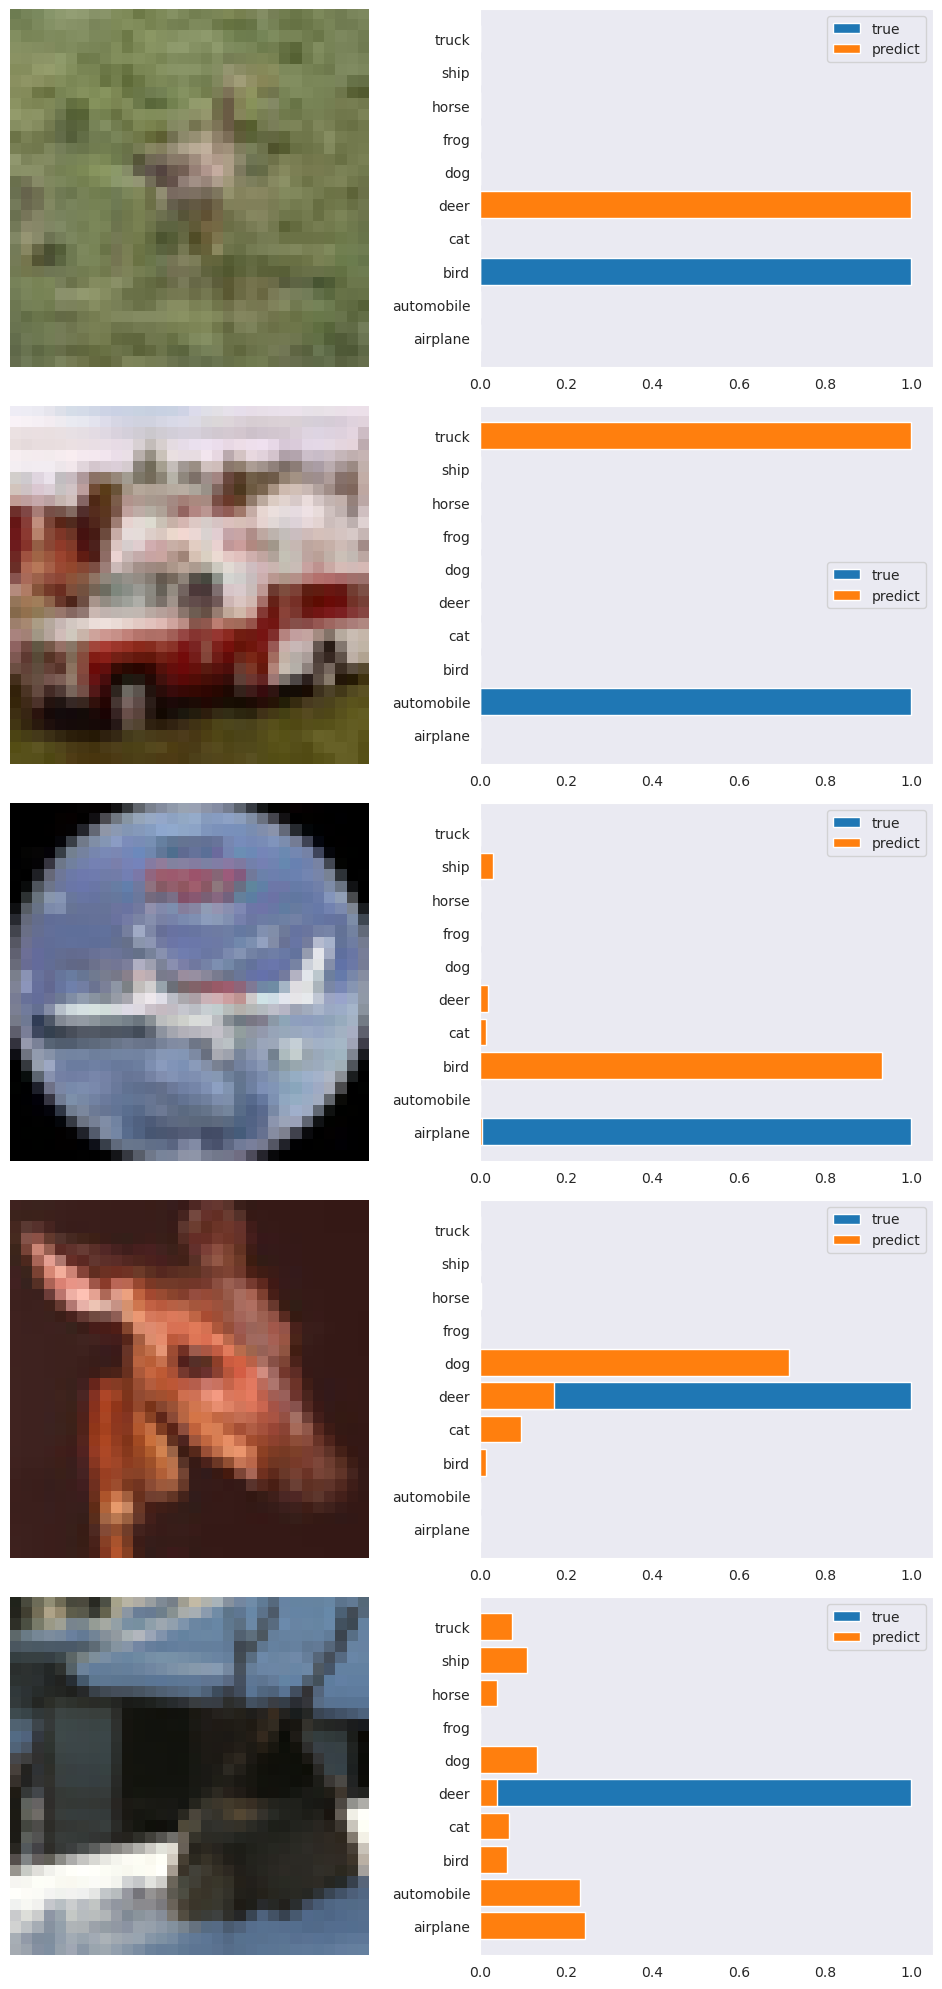

In [52]:
visualize_dataset(wrong_pred_datas['progressive_concave'],nshow=5)

## Unprogressive

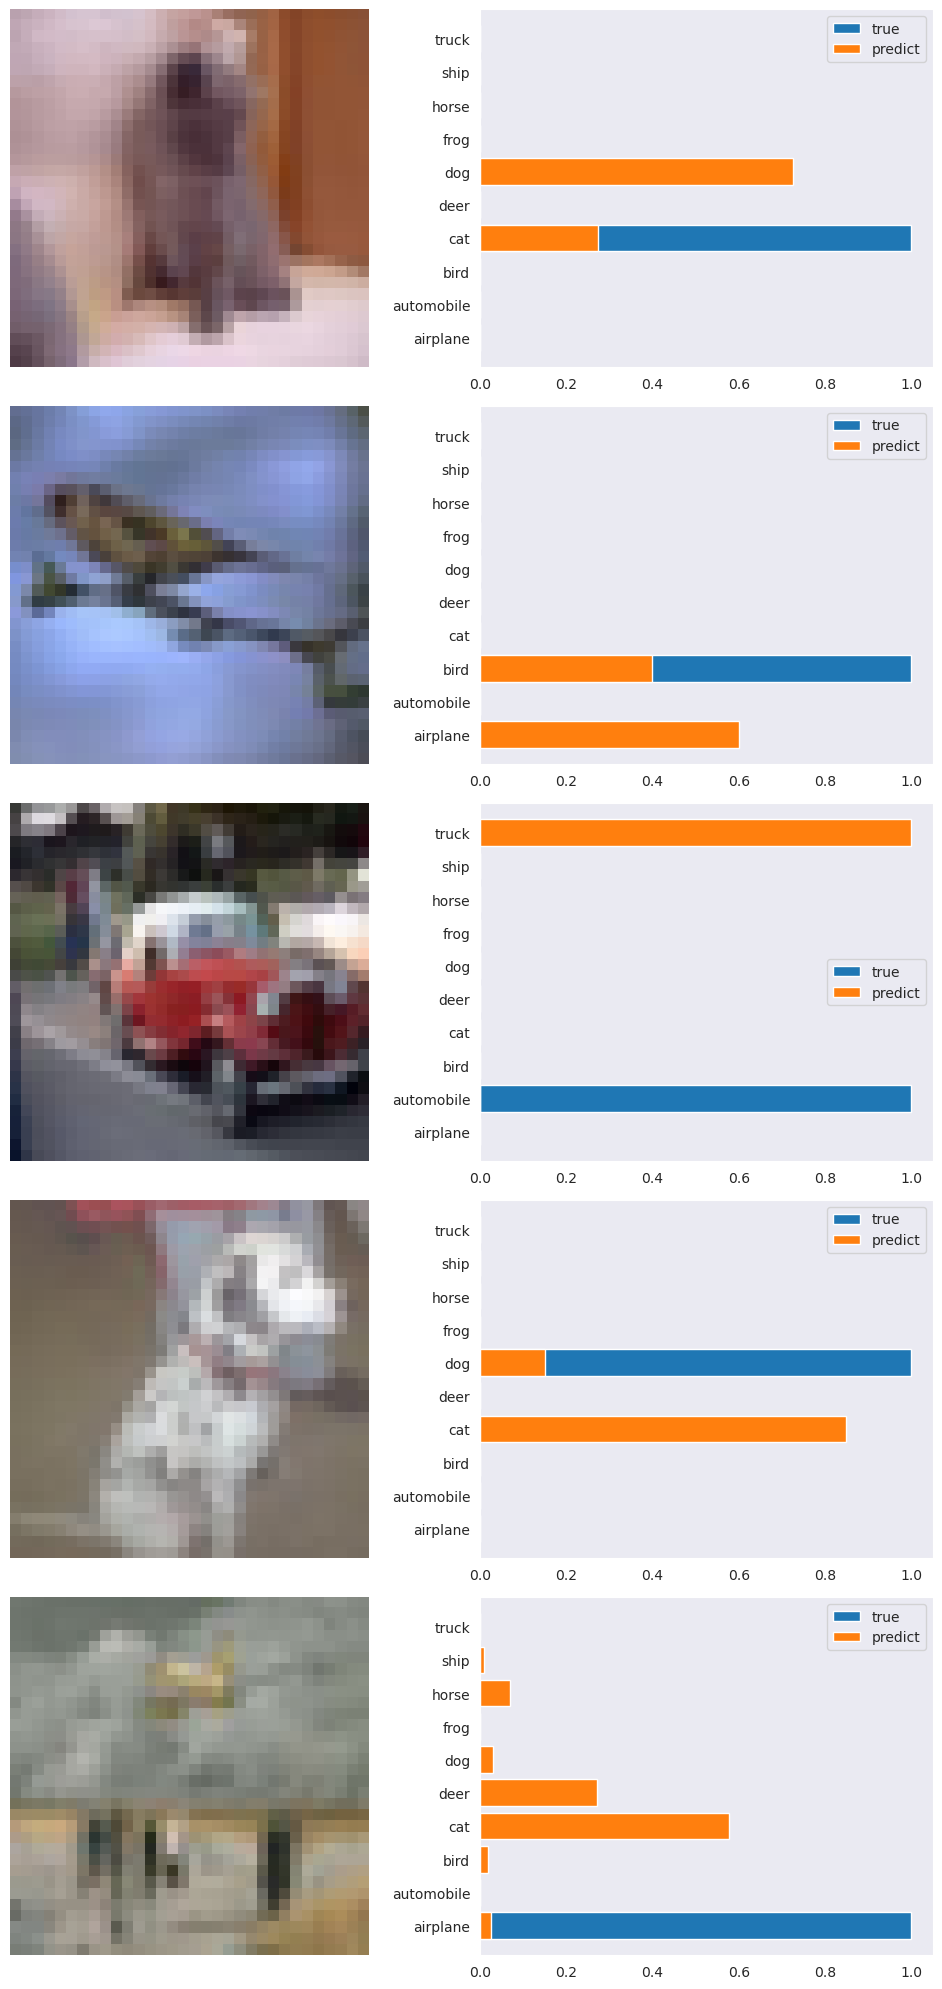

In [53]:
visualize_dataset(wrong_pred_datas['unprogressive'],nshow=5)

## Ground

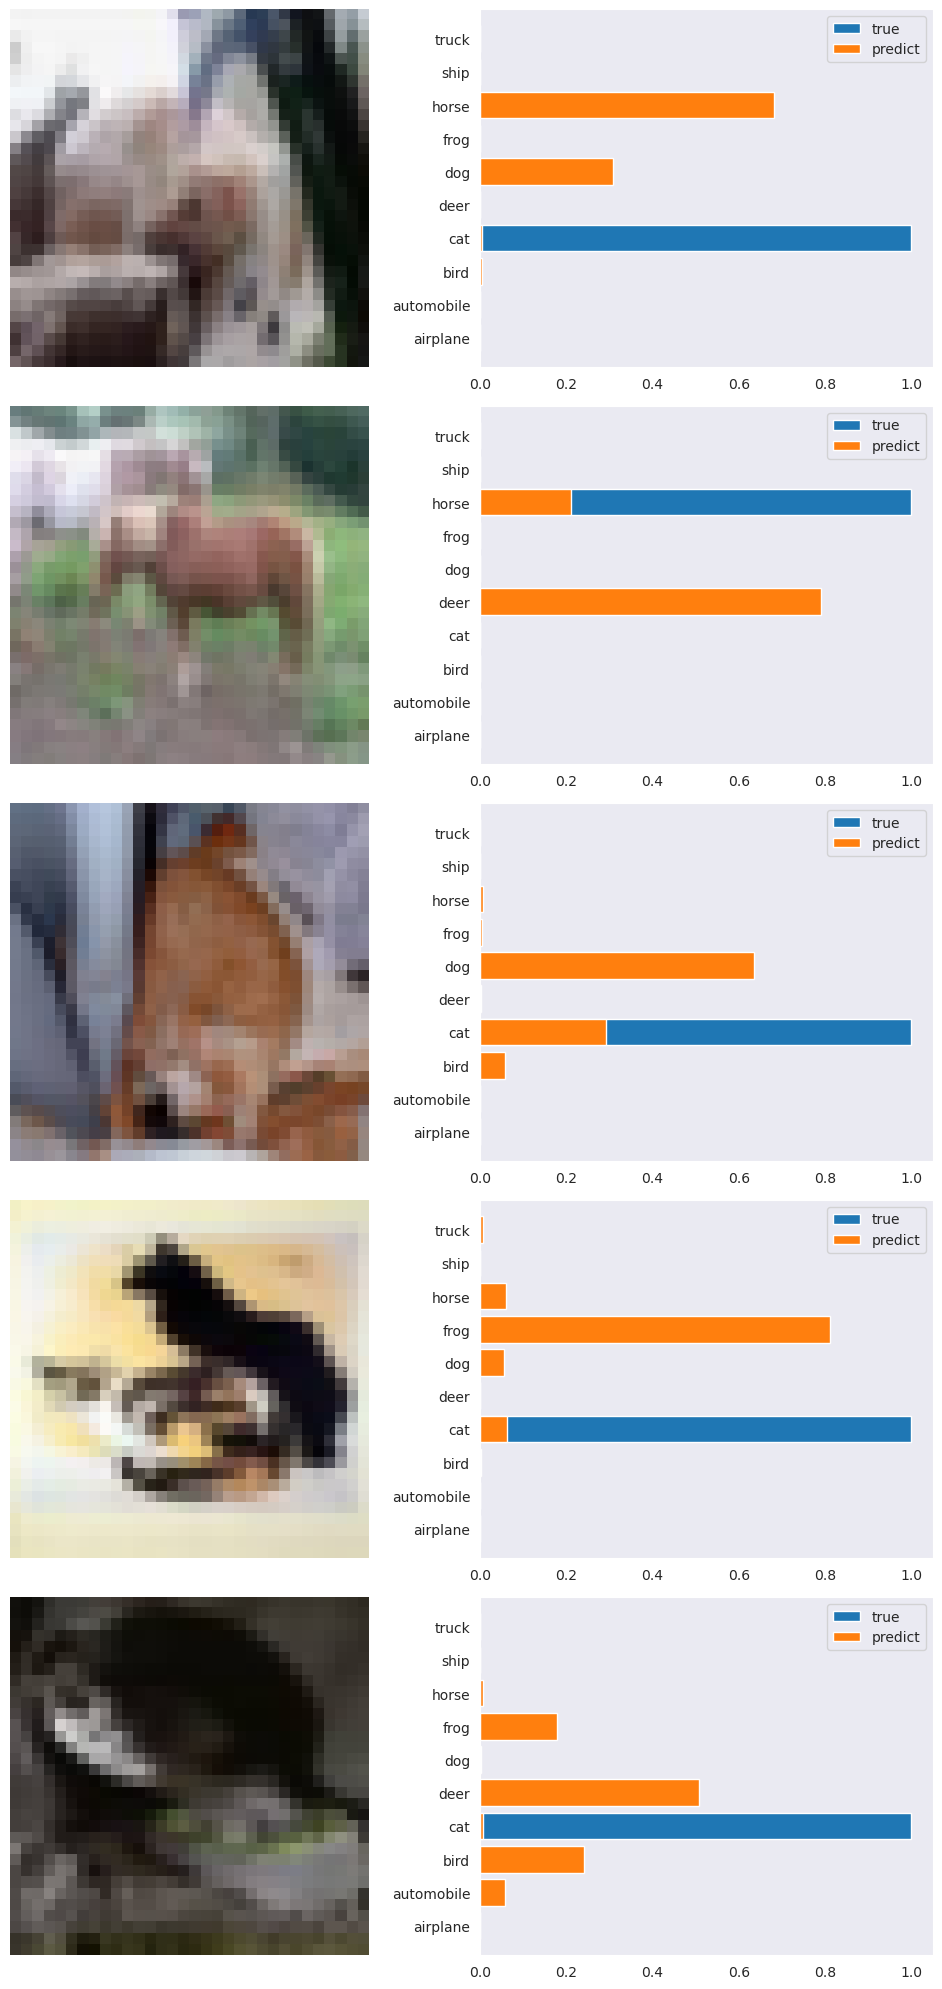

In [54]:
visualize_dataset(wrong_pred_datas['ground'],nshow=5)

## ConvNext-ified

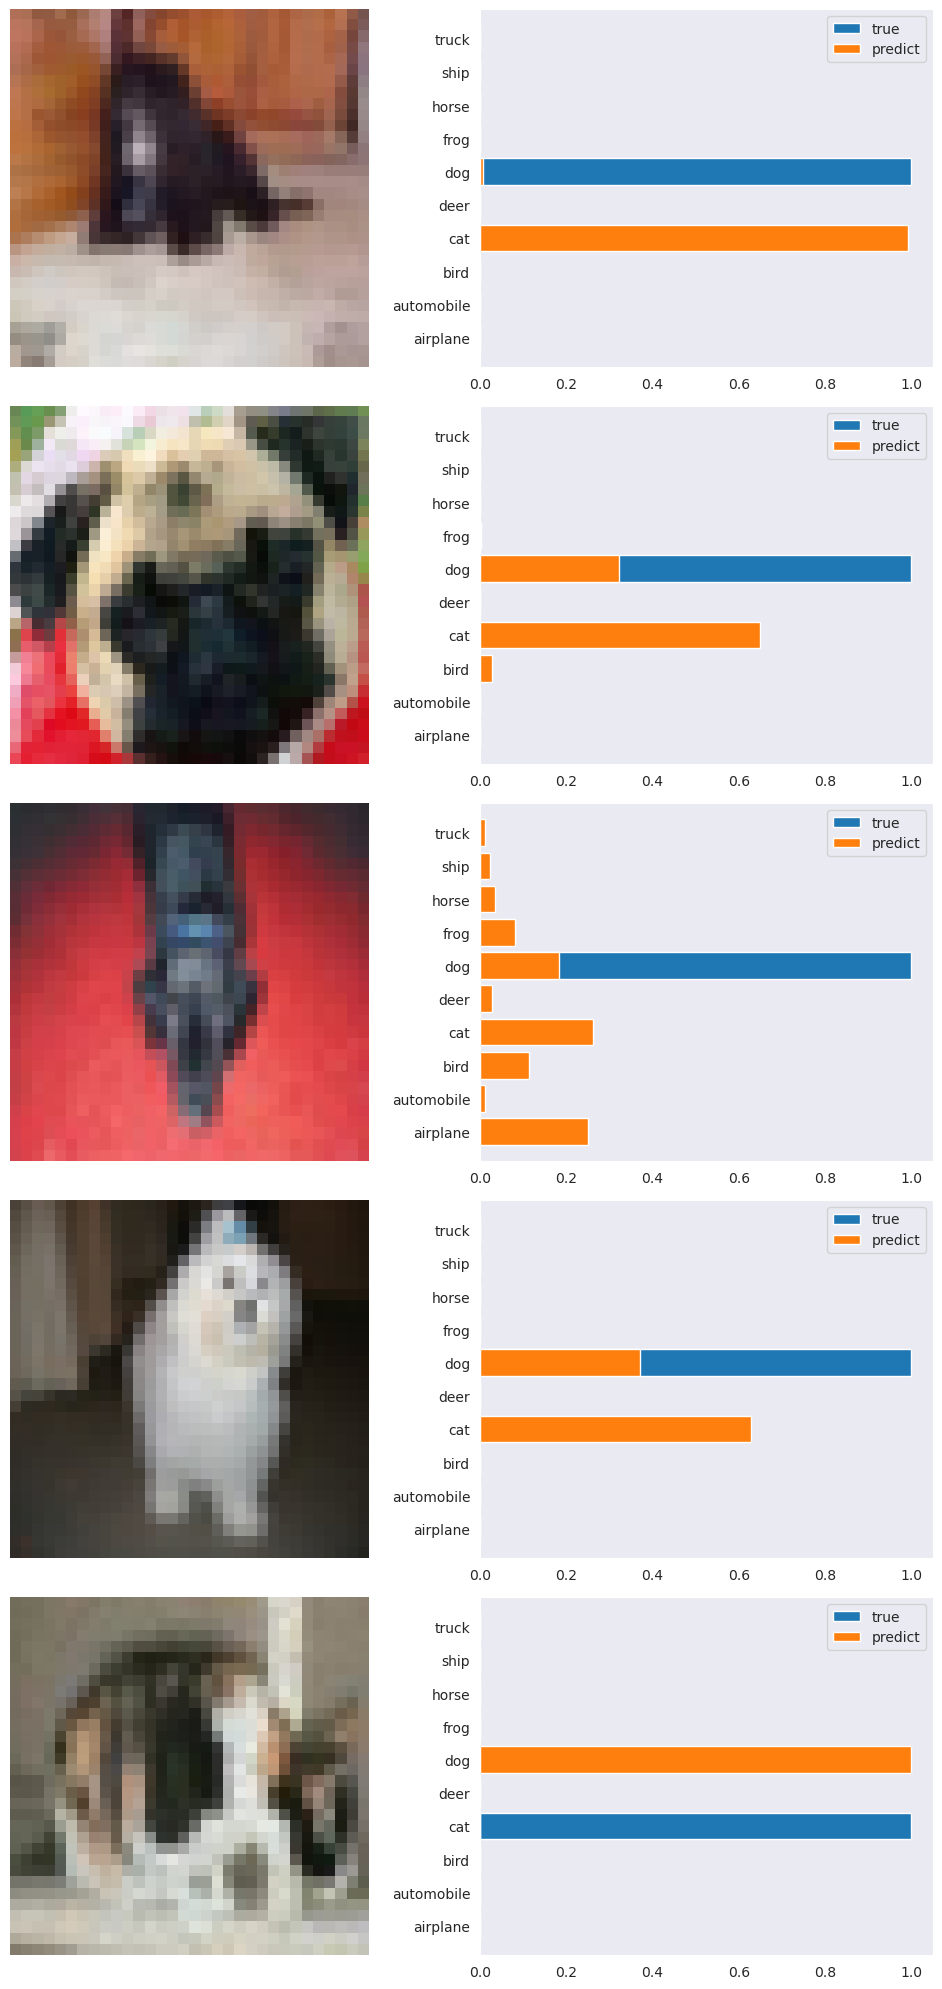

In [55]:
visualize_dataset(wrong_pred_datas['progressive_extended2'],nshow=5)

'r%d' % block.num_repeat,\
'k%d' % block.kernel_size,\
's%d' % block.strides,\
'e%s' % block.expand_ratio,\
'i%d' % block.input_filters,\
'o%d' % block.output_filters,\
'c%d' % block.conv_type,\
'f%d' % block.fused_conv,

v2_base_block = [  # The baseline config for v2 models.\
    'r1_k3_s1_e1_i32_o16_c1',\
    'r2_k3_s2_e4_i16_o32_c1',\
    'r2_k3_s2_e4_i32_o48_c1',\
    'r3_k3_s2_e4_i48_o96_se0.25',\
    'r5_k3_s1_e6_i96_o112_se0.25',\
    'r8_k3_s2_e6_i112_o192_se0.25',\
]


v2_s_block = [  # about base * (width1.4, depth1.8)\
    'r2_k3_s1_e1_i24_o24_c1',\
    'r4_k3_s2_e4_i24_o48_c1',\
    'r4_k3_s2_e4_i48_o64_c1',\
    'r6_k3_s2_e4_i64_o128_se0.25',\
    'r9_k3_s1_e6_i128_o160_se0.25',\
    'r15_k3_s2_e6_i160_o256_se0.25',\
]

# (block, width, depth, train_size, eval_size, dropout, randaug, mixup, aug)\
'efficientnetv2-s':  # 83.9% @ 22M\
    (v2_s_block, 1.0, 1.0, 300, 384, 0.2, 10, 0, 'randaug'),\
'efficientnetv2-b0':  # 78.7% @ 7M params\
    (v2_base_block, 1.0, 1.0, 192, 224, 0.2, 0, 0, 'effnetv1_autoaug'),\
'efficientnetv2-b1':  # 79.8% @ 8M params\
    (v2_base_block, 1.0, 1.1, 192, 240, 0.2, 0, 0, 'effnetv1_autoaug'),\
'efficientnetv2-b2':  # 80.5% @ 10M params\
    (v2_base_block, 1.1, 1.2, 208, 260, 0.3, 0, 0, 'effnetv1_autoaug'),\
'efficientnetv2-b3':  # 82.1% @ 14M params\
    (v2_base_block, 1.2, 1.4, 240, 300, 0.3, 0, 0, 'effnetv1_autoaug'),\

model=dict(\
        model_name='efficientnet-b0',\
        data_format='channels_last',\
        feature_size=1280,\
        bn_type=None,   # 'tpu_bn',\
        bn_momentum=0.9,\
        bn_epsilon=1e-3,\
        gn_groups=8,\
        depth_divisor=8,\
        min_depth=8,\
        act_fn='silu',\
        survival_prob=0.8,\
        local_pooling=False,\
        headbias=None,\
        conv_dropout=None,\
        dropout_rate=None,\
        depth_coefficient=None,\
        width_coefficient=None,\
        blocks_args=None,\
        num_classes=1000,  # must be the same as data.num_classes\
),
# train related params.
train=dict(\
    stages=0,\
    epochs=350,\
    min_steps=0,\
    optimizer='rmsprop',\
    lr_sched='exponential',\
    lr_base=0.016,\
    lr_decay_epoch=2.4,\
    lr_decay_factor=0.97,\
    lr_warmup_epoch=5,\
    lr_min=0,\
    ema_decay=0.9999,\
    weight_decay=1e-5,\
    weight_decay_inc=0.0,\
    weight_decay_exclude='.*(bias|gamma|beta).*',\
    label_smoothing=0.1,\
    gclip=0,\
    batch_size=4096,\
    isize=None,\
    split=None,  # dataset split, default to 'train'\
    loss_type=None,  # loss type: sigmoid or softmax\
    ft_init_ckpt=None,\
    ft_init_ema=True,\
    varsexp=None,  # trainable variables.\
    sched=None,  # schedule\
),\
eval=dict(\
    batch_size=8,\
    isize=None,  # image size\
    split=None,  # dataset split, default to 'eval'\
),
# data related params.
data=dict(\
    ds_name='imagenet',\
    augname='randaug',  # or 'autoaug'\
    ra_num_layers=2,\
    ram=15,\
    mixup_alpha=0.,\
    cutmix_alpha=0.,\
    ibase=128,\
    cache=True,\
    resize=None,\
    data_dir=None,\
    multiclass=None,\
    num_classes=1000,\
    tfds_name=None,\
    try_gcs=False,\
    tfds_split=None,\
    splits=dict(\
        train=dict(num_images=None, files=None, tfds_split=None, slice=None),\
        eval=dict(num_images=None, files=None, tfds_split=None, slice=None),\
        minival=dict(num_images=None, files=None, tfds_split=None, slice=None),\
        trainval=dict(num_images=None, files=None, tfds_split=None, slice=None),\
    ),\
),\
runtime=dict(\
    iterations_per_loop=1000,  # larger value has better utilization.\
    skip_host_call=False,\
    mixed_precision=True,\
    use_async_checkpointing=False,\
    log_step_count_steps=64,\
    keep_checkpoint_max=5,\
    keep_checkpoint_every_n_hours=5,\
    strategy='tpu',  # None, gpu, tpu\
))